# **DESAFIO 2 G2** 
# **Dataset Properati - Modelado de datos.**
---

<a id="section_toc"></a> 
## Tabla de Contenidos

[Intro](#sec_intro)

Observaciones preliminares dataset

$\hspace{.5cm}$[Importaciones y carga de dataset](#sec_imp)

$\hspace{.5cm}$[Analisis previos y distribuciones de variables](#sec_adv)
  
$\hspace{.5cm}$[Outliers](#sec_outliers)
  
$\hspace{.9cm}$[Outliers variable target](#sec_outliers_target)
  
$\hspace{.5cm}$[Imputaciones](#sec_imp)

$\hspace{.5cm}$[Variables dummies](#sec_dummies)

Depuracion

$\hspace{.5cm}$[Eliminacion de nulos y columnas](#section_re)

Modelado

$\hspace{.5cm}$[Borrado de registros duplicados](#section_drd)

$\hspace{.5cm}$[Borrado de registros sin información completa](#section_drii)



---



## Importacion y carga del dataset

#### Bibliotecas de operacion basica

In [1]:
import pandas as pd
import numpy as np
import re
import random

#### Bibliotecas de visualizacion y parametrizaciones generales

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from math import pi
from bokeh.io import output_notebook, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.models import Legend, LabelSet, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [4]:
sns.set(font_scale=1.15)
sns.set_style("whitegrid")

In [5]:
pd.set_option('display.max_colwidth', 1500)
pd.set_option('display.max_rows', 400)

In [6]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#### Carga de Dataset e inspeccion basica

In [7]:
data_location = 'https://github.com/DHDSDesafios/DH_DS_desafio_2_properati/raw/master/data/properatid2caba.zip'
data = pd.read_csv(data_location, compression='zip', encoding="utf-8")

In [8]:
data.sample(3)

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero,subte,seguridad,metrobus
19588,78978,apartment,|Argentina|Capital Federal|Villa Luro|,Argentina,Capital Federal,"-34.6391994728,-58.5099134768",-34.639199,-58.509913,105000.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
12501,51071,apartment,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,"-34.5620844,-58.4566864",-34.562084,-58.456686,160000.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0
5621,25518,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


---
## Analisis preliminar y distribuciones de variables

### Caracteristicas generales del dataset

datosCol(serie) - Funcion que retorna diccionario con los datos de una Serie / Columna del DataFrame a analizar:

Campos:
 - nombre columna.
 - tipo de dato Pandas serie.
 - cantidad de registros en la serie.
 - cantidad de nulos en la serie.
 - porcentaje de nulos en la serie.
 - cantidad de valores unicos en la serie.
 - valor mas repetido en la serie.
 - valor maximo en la serie.
 - valor minimos en la serie.
 - media, mediana y desvio estandar en la serie.
 - distribucion de cuantiles.
 - tipos de datos sobre los valores incluidos en la serie.

In [9]:
def datosCol(col=None):
    try:
        if col.dtype != object:
            return {
                    'nombre': col.name,
                    'series_dt': col.dtype,
                    'nulos': int(len(col) - col.describe()[0]), 
                    'nulos_porcentaje': round(col.isnull().sum() / col.size*100, 2),
                    'unicos': int(len(col.value_counts())),
                    'mas_repetido': col.value_counts().index[0],
                    'minimo': round(col.min(), 2),
                    'maximo': round(col.max(), 2),
                    'media': round(col.describe()[1], 2),
                    'mediana': col.median(),
                    'desvio': round(col.describe()[2], 2),
                    'q25': col.describe()[4],
                    'q50': col.describe()[5],
                    'q75': col.describe()[6],
                    'values_dt': [x for x in col.apply(lambda x: type(x)).value_counts().index]
                   }
        else:
            return {
                    'nombre': col.name,
                    'series_dt': col.dtype,
                    'nulos': col.isnull().sum(),
                    'nulos_porcentaje': round(col.isnull().sum() / col.size*100, 2),
                    'unicos': int(col.describe()[1]), 
                    'mas_repetido': col.describe()[2],
                    'nulos': col.isnull().sum(),
                    'frecuencia': int(col.describe()[3]),
                    'values_dt': [x for x in col.apply(lambda x: type(x)).value_counts().index]
                   }
    except:
        return 'use a valid pandas Series'

In [10]:
data_info = pd.DataFrame([datosCol(data[x]) for x in ['property_type', 'place_name', 'price_aprox_usd', 'floor', 'rooms',
                                                      'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2', 'expenses',
                                                      'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
                                                      'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad', 'metrobus'] ])
data_info

,nombre,series_dt,nulos,nulos_porcentaje,unicos,mas_repetido,frecuencia,values_dt,minimo,maximo,media,mediana,desvio,q25,q50,q75
0,property_type,object,0,0.00,4,apartment,24713.0,[<class 'str'>],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,place_name,object,0,0.00,62,Belgrano,2745.0,[<class 'str'>],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,price_aprox_usd,float64,1532,5.21,5237,120000,NaN,[<class 'float'>],5103.61,46545445.00,263567.97,155000.00,452774.30,104724.465,155000.00,278000.00
3,floor,float64,26480,90.13,82,1,NaN,[<class 'float'>],1.00,2509.00,12.64,4.00,83.22,2.000,4.00,7.00
4,rooms,float64,11341,38.60,17,2,NaN,[<class 'float'>],1.00,22.00,2.55,2.00,1.47,1.000,2.00,3.00
5,price_usd_per_m2,float64,7227,24.60,10452,2500,NaN,[<class 'float'>],13.80,206333.33,3146.57,2486.41,3722.99,1988.950,2486.41,3094.27
6,price_per_m2,float64,2512,8.55,12115,2500,NaN,[<class 'float'>],3.21,2600000.00,3839.77,2727.27,18864.14,2177.420,2727.27,3440.00
7,surface_total_in_m2,float64,3638,12.38,734,40,NaN,[<class 'float'>],0.00,200000.00,116.88,62.00,1268.88,42.000,62.00,110.00
8,expenses,float64,23009,78.32,740,1,NaN,[<class 'float'>],1.00,10001500.00,6404.74,2000.00,177179.51,1200.000,2000.00,3800.00
9,surface_covered_in_m2,float64,1170,3.98,620,30,NaN,[<class 'float'>],0.00,10958.00,91.43,55.00,203.58,38.000,55.00,95.00


In [11]:
data.columns

Index(['Id_caso', 'property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad',
       'metrobus'],
      dtype='object')

In [12]:
data.dtypes.value_counts()

float64    24
object     14
int64       1
dtype: int64

In [13]:
data.shape

(29380, 39)

In [14]:
data.expenses.sample(20)

18426     950.0
28409    1788.0
11137       NaN
1470        NaN
3835        NaN
24246       NaN
15653       NaN
28114       NaN
26322       NaN
2777        NaN
3529        NaN
18857    2500.0
2212        NaN
6493        NaN
22519    2500.0
25976       NaN
10432       NaN
9134        NaN
12555       NaN
4398        NaN
Name: expenses, dtype: float64

**El dataset presenta las siguientes caracteristicas:**

 * Cuenta con 29380 registros con 39 variables.
 
 * 25 variables son numericas y 14 son variables de tipo _object_.
 
 * De las 25 variables numericas se encuentran:
 
  * 12 variales numericas continuas: _'lat-lon', 'lat', 'lon', 'price', 'price_aprox_local_currency', 'price_aprox_usd', 'expenses', 'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2', 'surface_covered_in_m2'_ y _'geonames_id'_.
  
  * 13 variables numericas discretas: _'floor', 'rooms','cochera', 'piscina', 'parrilla', 'baulera', 'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad'_ y
       _'metrobus'_.
       
 * Los mayores porcentajes de nulos se encuentran entre el conjunto de amenities: _cochera', 'piscina', 'parrilla', 'baulera', 'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad' y 'metrobus'_ y la variable _'floor'_.
 

#### Estadarizacion de valores de amenities.

In [15]:
data.loc[data.balcon.notnull(), 'balcon'] = 1
data.loc[data.balcon.isnull(), 'balcon'] = 0
data["balcon"] =  pd.to_numeric(data["balcon"])

data.loc[data.cochera.isnull(), 'cochera'] = 0
data.cochera.astype('uint8')

data.loc[data.piscina.isnull(), 'piscina'] = 0
data.piscina.astype('uint8')

data.loc[data.lavadero.isnull(), 'lavadero'] = 0
data.lavadero.astype('uint8')

data.loc[data.parrilla.isnull(), 'parrilla'] = 0
data.parrilla.astype('uint8')

data.loc[data.terraza.isnull(), 'terraza'] = 0
data.terraza.astype('uint8')

data.loc[data.jardin.isnull(), 'jardin'] = 0
data.jardin.astype('uint8')

data.loc[data.baulera.isnull(), 'baulera'] = 0
data.baulera.astype('uint8')

data.loc[data.seguridad.isnull(), 'seguridad'] = 0
data.seguridad.astype('uint8')

data.loc[data.metrobus.isnull(), 'metrobus'] = 0
data.metrobus.astype('uint8')

data.loc[data.subte.isnull(), 'subte'] = 0
data.subte.astype('uint8')

0        0
1        0
2        0
3        0
4        0
        ..
29375    0
29376    0
29377    0
29378    0
29379    1
Name: subte, Length: 29380, dtype: uint8

### Distribuciones basicas de variables numericas continuas

 * 'price_per_m2'
 * 'price_usd_per_m2'
 * 'surface_total_in_m2'
 * 'surface_covered_in_m2'

#### Visualizacion general de distribuiciones segun variables numericas continuas

In [16]:
prop_apartment = data.property_type == 'apartment'
prop_store = data.property_type == 'store'
prop_ph = data.property_type == 'PH'
prop_house = data.property_type == 'house'

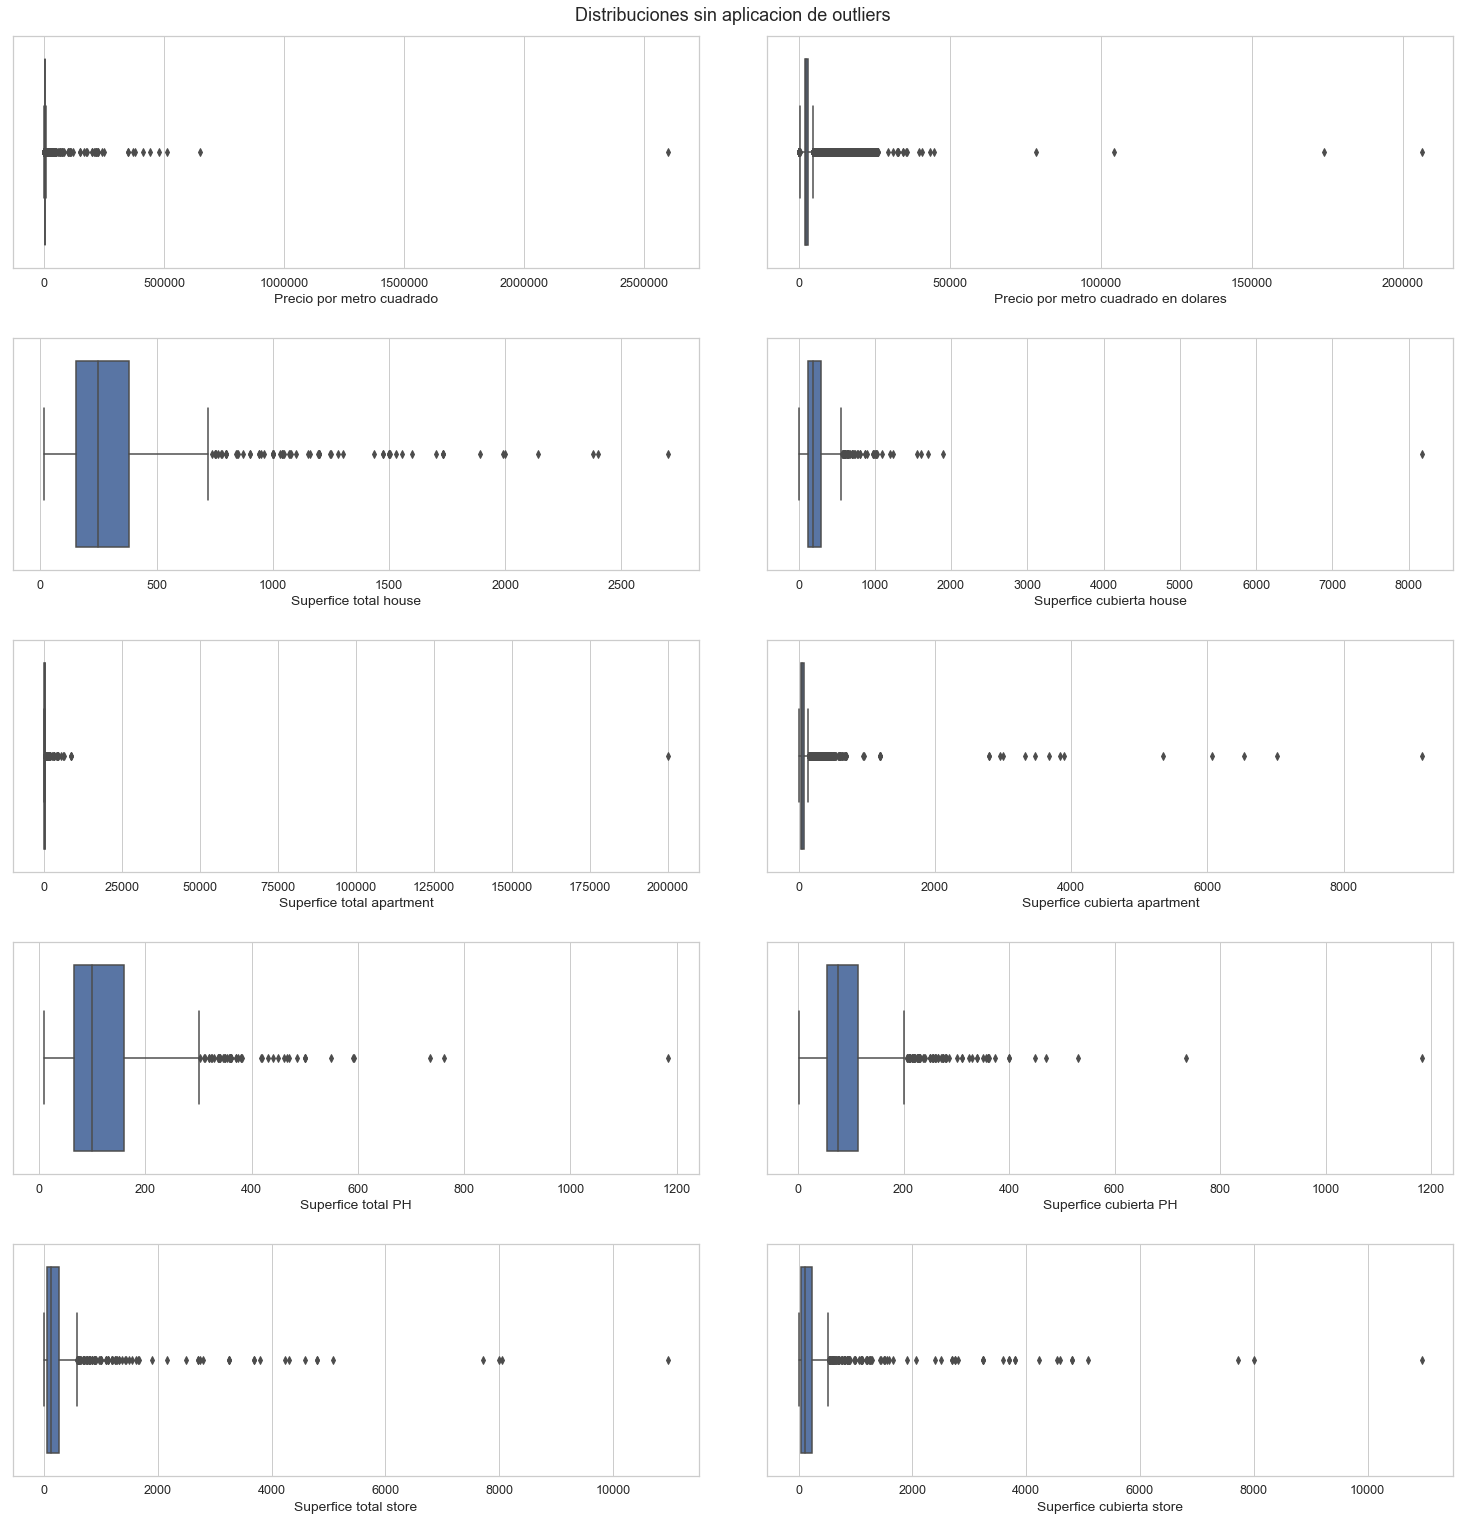

In [17]:
fig, axs = plt.subplots(5,2,figsize=(20,20))
fig.suptitle('Distribuciones sin aplicacion de outliers', y=1.02, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)

sns.boxplot(x='price_per_m2', data=data, ax=axs[0,0])
axs[0,0].set(xlabel='Precio por metro cuadrado') 

sns.boxplot(x='price_usd_per_m2', data=data, ax=axs[0,1])
axs[0,1].set(xlabel='Precio por metro cuadrado en dolares')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_house, :], ax=axs[1,0])
axs[1,0].set(xlabel='Superfice total house')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_house, :], ax=axs[1,1])
axs[1,1].set(xlabel='Superfice cubierta house')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_apartment, :], ax=axs[2,0])
axs[2,0].set(xlabel='Superfice total apartment')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_apartment, :], ax=axs[2,1])
axs[2,1].set(xlabel='Superfice cubierta apartment')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_ph, :], ax=axs[3,0])
axs[3,0].set(xlabel='Superfice total PH')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_ph, :], ax=axs[3,1])
axs[3,1].set(xlabel='Superfice cubierta PH')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_store, :], ax=axs[4,0])
axs[4,0].set(xlabel='Superfice total store')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_store, :], ax=axs[4,1])
axs[4,1].set(xlabel='Superfice cubierta store')

plt.show()

#### Distribucion de variable objetivo segun barrio

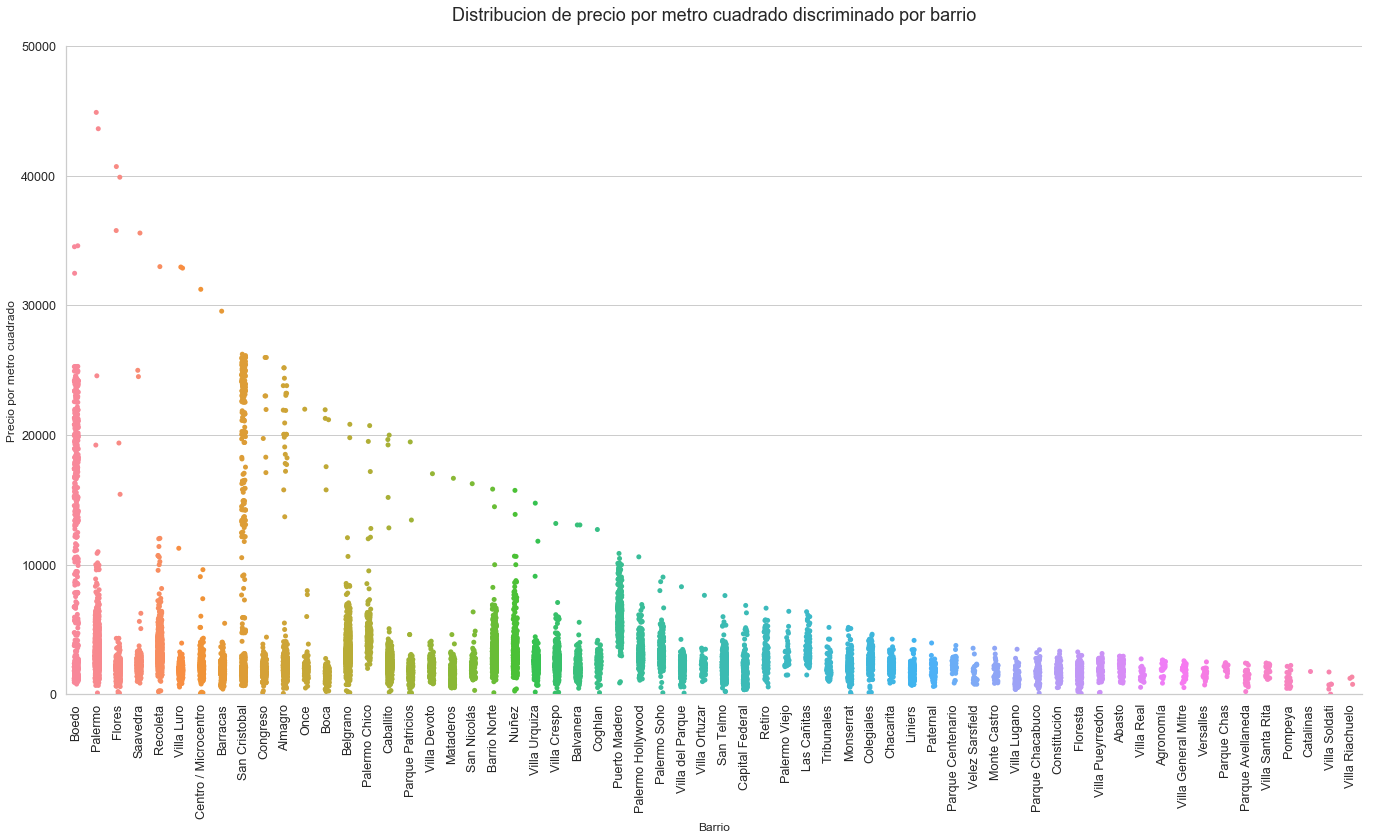

In [18]:
g = sns.catplot(data=data.sort_values(by=['price_usd_per_m2'], ascending=False), x='place_name', y='price_usd_per_m2', height=9, aspect=2)
g.set_xticklabels(rotation=90)
g.set(ylim=(0,50000))

plt.title("Distribucion de precio por metro cuadrado discriminado por barrio", size=18, y=1.03)
plt.xlabel('Barrio', size=12)
plt.ylabel('Precio por metro cuadrado', size=12)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)

plt.show()

catplot con distribucion de precios por metro cuadrado desagregado por barrio.
llama la atencion la cantidad de registros que evidencian un alta cantidad y alto valor de precio por metro cuadrado en barrios que no son los lideres en precio

se corto el tope maximo de la escala solo a fin ilustrativo, para evidenciar claramete el estado de la distribucion

https://www.reporteinmobiliario.com/nuke/article3269-datos-estadisticos-de-precios-en-la-ciudad-de-buenos-aires.html
    
http://www.maureinmobiliaria.com/metro-cuadrado/
    
https://www.on24.com.ar/negocios/a-cuanto-esta-el-metro-cuadrado-hoy-en-caba-y-gran-buenos-aires/
    
https://fortuna.perfil.com/2019-11-21-207654-vivienda-a-cuanto-esta-el-m2-segun-los-barrios-en-caba/

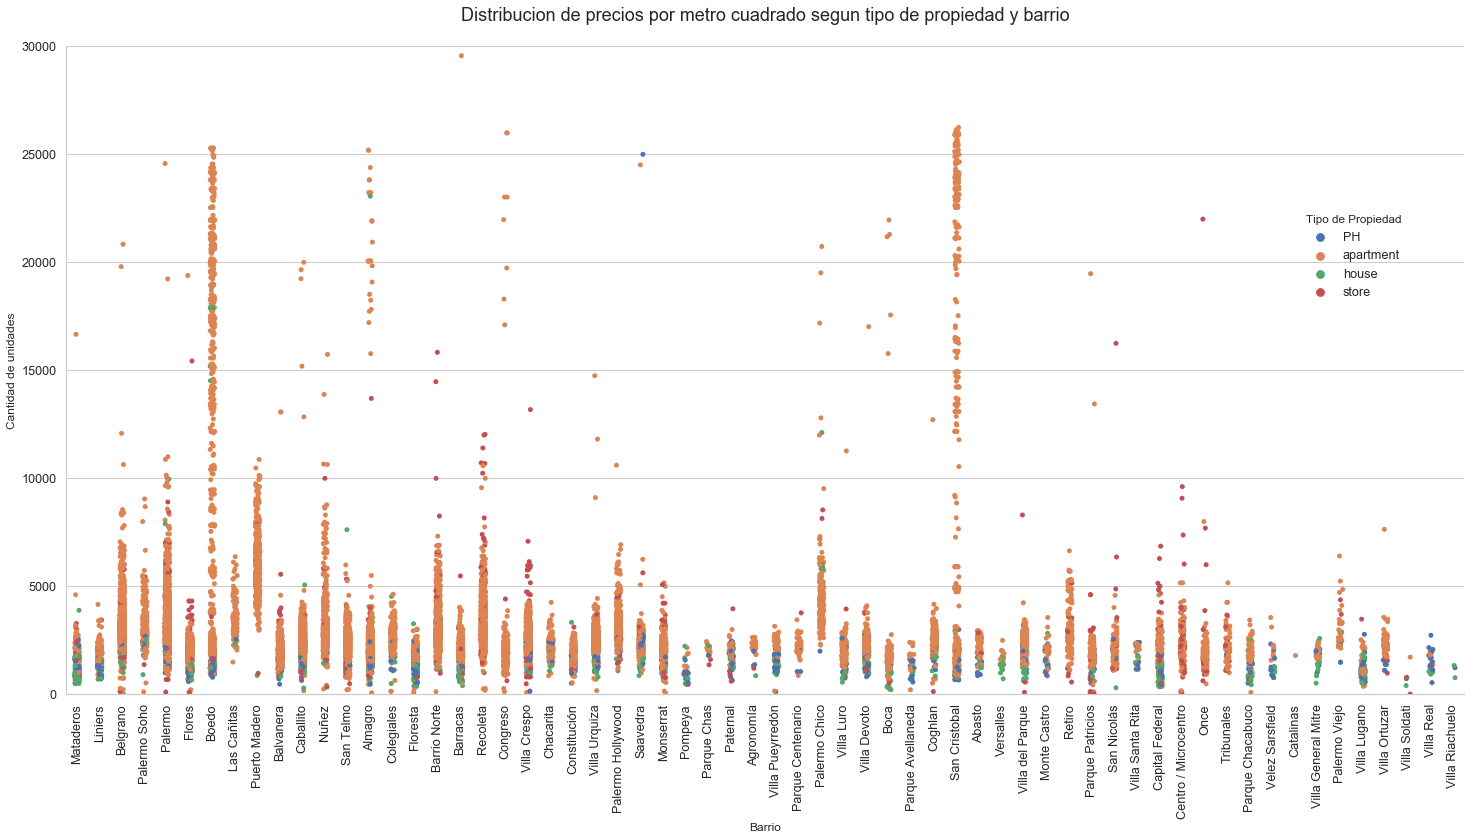

In [19]:
g = sns.catplot(x='place_name', y='price_usd_per_m2', hue='property_type', data=data, height=9, aspect=2, legend_out=True)
g.set(ylim=(0,30000))
g.set_xticklabels(rotation=90)

plt.title("Distribucion de precios por metro cuadrado segun tipo de propiedad y barrio", size=18, y=1.03)
plt.xlabel('Barrio', size=12)
plt.ylabel('Cantidad de unidades', size=12)

g._legend.set_title('Tipo de Propiedad')
g._legend.set_bbox_to_anchor((1.01,0.9))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)

plt.show()

#### Histograma de distribución de precios con prueba preliminar de outliers

In [20]:
lower, upper = data.price_usd_per_m2.quantile(.01), data.price_usd_per_m2.quantile(.97)
lower, upper
def price_m2_is_not_outlier(price_usd_per_m2):
    return (lower <= price_usd_per_m2) & (price_usd_per_m2 <= upper)

price_m2_is_not_outlier_mask = data.price_usd_per_m2.apply(price_m2_is_not_outlier)
limpio = data[price_m2_is_not_outlier_mask]

In [21]:
hist_belgrano = limpio.loc[limpio.place_name=='Belgrano', 'price_usd_per_m2']
hist_puerto_madero = limpio.loc[limpio.place_name=='Puerto Madero', 'price_usd_per_m2']
histo_villa_crespo = limpio.loc[limpio.place_name=='Villa Crespo', 'price_usd_per_m2']
histo_boedo = limpio.loc[limpio.place_name=='Boedo', 'price_usd_per_m2']
histo_san_cristobal = limpio.loc[limpio.place_name=='San Cristobal', 'price_usd_per_m2']

In [22]:
data_dist_1 = hist_belgrano
data_dist_2 = hist_puerto_madero
data_dist_3 = histo_villa_crespo
data_dist_4 = histo_boedo
data_dist_5 = histo_san_cristobal

hist_belgrano, edges_1 = np.histogram(data_dist_1, density=True, bins=100)
hist_puerto_madero, edges_2 = np.histogram(data_dist_2, density=True, bins=100)
histo_villa_crespo, edges_3 = np.histogram(data_dist_3, density=True, bins=100)
histo_boedo, edges_4 = np.histogram(data_dist_4, density=True, bins=100)
histo_san_cristobal, edges_5 = np.histogram(data_dist_5, density=True, bins=100)

p = figure(title="Distribución de precio USD por m2 según barrio")

p.quad(top=hist_belgrano, bottom=0, left=edges_1[:-1], right=edges_1[1:], line_color="white", legend_label="Belgrano")
p.quad(top=hist_puerto_madero, bottom=0, left=edges_2[:-1], right=edges_2[1:], line_color="white",fill_color='red',fill_alpha=0.2, legend_label="Puerto Madero")
p.quad(top=histo_villa_crespo, bottom=0, left=edges_3[:-1], right=edges_3[1:], line_color="white",fill_color='green',fill_alpha=0.2, legend_label="Villa Crespo")
p.quad(top=histo_boedo, bottom=0, left=edges_4[:-1], right=edges_4[1:], line_color="white",fill_color='yellow',fill_alpha=0.4, legend_label="Boedo")
p.quad(top=histo_san_cristobal, bottom=0, left=edges_5[:-1], right=edges_5[1:], line_color="white",fill_color='blue',fill_alpha=0.2, legend_label="San Cristobal")
p.plot_width=1280
p.plot_height=700

show(p)

### Distribuciones basicas de variables numericas discretas

#### Registros por barrio
De los 62 distritos registrados en Capital Federal, 20 acumulan el 75% de los registros

In [23]:
top_20_barrios = data.groupby('place_name')['property_type'].count().sort_values(ascending=False)[:20]
(top_20_barrios.sum() / data.shape[0])*100

75.1565690946222

In [24]:
top_20_barrios = top_20_barrios.append(pd.Series(data.shape[0] - top_20_barrios.sum(),index=['otros']))

In [25]:
data_pie = top_20_barrios.reset_index(name='valor').rename(columns={'index':'barrio'})
data_pie['angulo'] = data_pie['valor']/data_pie['valor'].sum() * 2*pi
data_pie['color'] = Category20c[20] + ('#2F4F4F',)

p = figure(plot_height=600, plot_width=900, title="Registros por Barrio", toolbar_location=None,
           tools="hover", tooltips="@barrio: @valor", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angulo', include_zero=True), end_angle=cumsum('angulo'),
        line_color="white", fill_color='color', legend_field='barrio', source=data_pie)


p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None
p.legend.label_text_font_size = '8pt'
p.legend.location = "top_right"

show(p)

In [26]:
top_50_barrios = data.groupby('place_name')['property_type'].count().sort_values(ascending=False)[:50]

In [27]:
prop_20_barrios_dpto = data.loc[(data.place_name.isin(top_20_barrios.index)) & (data.property_type == 'apartment')].groupby('place_name')['property_type']
prop_20_barrios_ph = data.loc[(data.place_name.isin(top_20_barrios.index)) & (data.property_type == 'PH')].groupby('place_name')['property_type']
prop_20_barrios_house = data.loc[(data.place_name.isin(top_20_barrios.index)) & (data.property_type == 'house')].groupby('place_name')['property_type']
prop_20_barrios_store = data.loc[(data.place_name.isin(top_20_barrios.index)) & (data.property_type == 'store')].groupby('place_name')['property_type']

In [28]:
barrios_prop = data.groupby('place_name')['property_type'].count().sort_values(ascending=False)

In [29]:
dummies = pd.get_dummies(data['property_type'], drop_first = False)
data_barrio_prop = data.loc[:,['place_name']].join(dummies)

In [30]:
barrios = list(data_barrio_prop.groupby('place_name').sum().sort_values(by='apartment',ascending=False).transpose().columns)
prop = list(data_barrio_prop.groupby('place_name').sum().sort_values(by='apartment',ascending=False).transpose().index)
colors = ['darkseagreen', 'salmon', 'aqua', 'gold']

data_bar = {'barrios' : barrios,
        'apartment'   : list(data_barrio_prop.groupby('place_name').sum().sort_values(by='apartment',ascending=False).transpose().iloc[1]),
        'PH'   : list(data_barrio_prop.groupby('place_name').sum().sort_values(by='apartment',ascending=False).transpose().iloc[0]),
        'house'   : list(data_barrio_prop.groupby('place_name').sum().sort_values(by='apartment',ascending=False).transpose().iloc[2]),
        'store'   : list(data_barrio_prop.groupby('place_name').sum().sort_values(by='apartment',ascending=False).transpose().iloc[3])}

p = figure(x_range=barrios, plot_width=1280, plot_height=800, title="Tipo de propiedad por barrio", toolbar_location=None, tools="")

p.vbar_stack(prop, x='barrios', width=0.9, color=colors, source=data_bar, legend_label=prop)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = "vertical"
p.legend.location = "top_right"
p.legend.orientation = "vertical"
p.legend.label_text_font_size = '8pt'

show(p)

In [31]:
atributos = data.loc[:,['property_type','place_name','piscina','parrilla','baulera','balcon','terraza','jardin','lavadero','subte','seguridad','metrobus']]
atributos_barrios = atributos.groupby('place_name').sum()

In [32]:
barrios = list(atributos_barrios.index)
atr = list(atributos_barrios.columns)
lista_val = atributos_barrios.transpose()
colors = Category20c[len(atr)]
dict_1 = {'barrios' : barrios}
dict_2 = dict(zip(atr,list(lista_val.values)))

data_bar_2 = {**dict_1, **dict_2}

p = figure(x_range=barrios, plot_width=1280, plot_height=800, title="Cantidad de atributos por barrio",
           toolbar_location=None, tools="")

p.vbar_stack(atr, width=0.9, color=colors, source=data_bar_2,x='barrios',legend_label=atr)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = "vertical"
p.legend.location = "top_right"
p.legend.orientation = "vertical"
p.legend.label_text_font_size = '8pt'

show(p)

## Correlaciones preliminares entre variables

### Correlacion entre variables numericas continuas con respecto a la variable target.

In [33]:
data_numericas_continuas = data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2']]

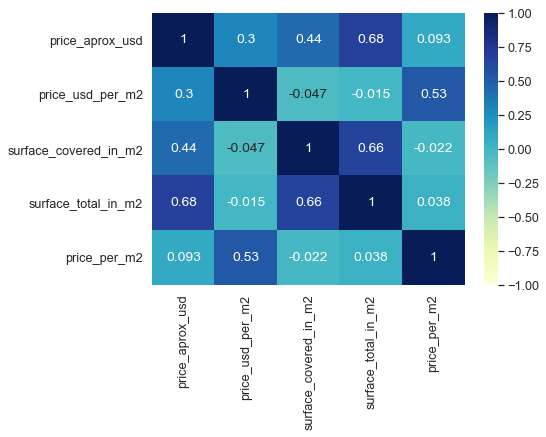

In [34]:
fig, ax = plt.subplots(figsize=(7,5))
g = sns.heatmap(data_numericas_continuas.corr(), annot=True, vmin=-1, vmax=1, cmap="YlGnBu")

#### Relaciones basicas entre variables numericas continuas:
 * Media.
 * Desvio estandar.
 * Maximos.
 * Minimos.

In [35]:
data_hm = data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2', 'property_type']]
cont_prop_mean = pd.pivot_table(data_hm, values=['price_usd_per_m2', 'price_per_m2','surface_covered_in_m2', 'surface_total_in_m2'], index='property_type', aggfunc=np.mean, margins = True)
cont_prop_std = pd.pivot_table(data_hm, values=['price_usd_per_m2', 'price_per_m2','surface_covered_in_m2', 'surface_total_in_m2'], index='property_type', aggfunc=np.std, margins = True)
cont_prop_max = pd.pivot_table(data_hm, values=['price_usd_per_m2', 'price_per_m2','surface_covered_in_m2', 'surface_total_in_m2'], index='property_type', aggfunc=np.min, margins = True)
cont_prop_min = pd.pivot_table(data_hm, values=['price_usd_per_m2', 'price_per_m2','surface_covered_in_m2', 'surface_total_in_m2'], index='property_type', aggfunc=np.max, margins = True)

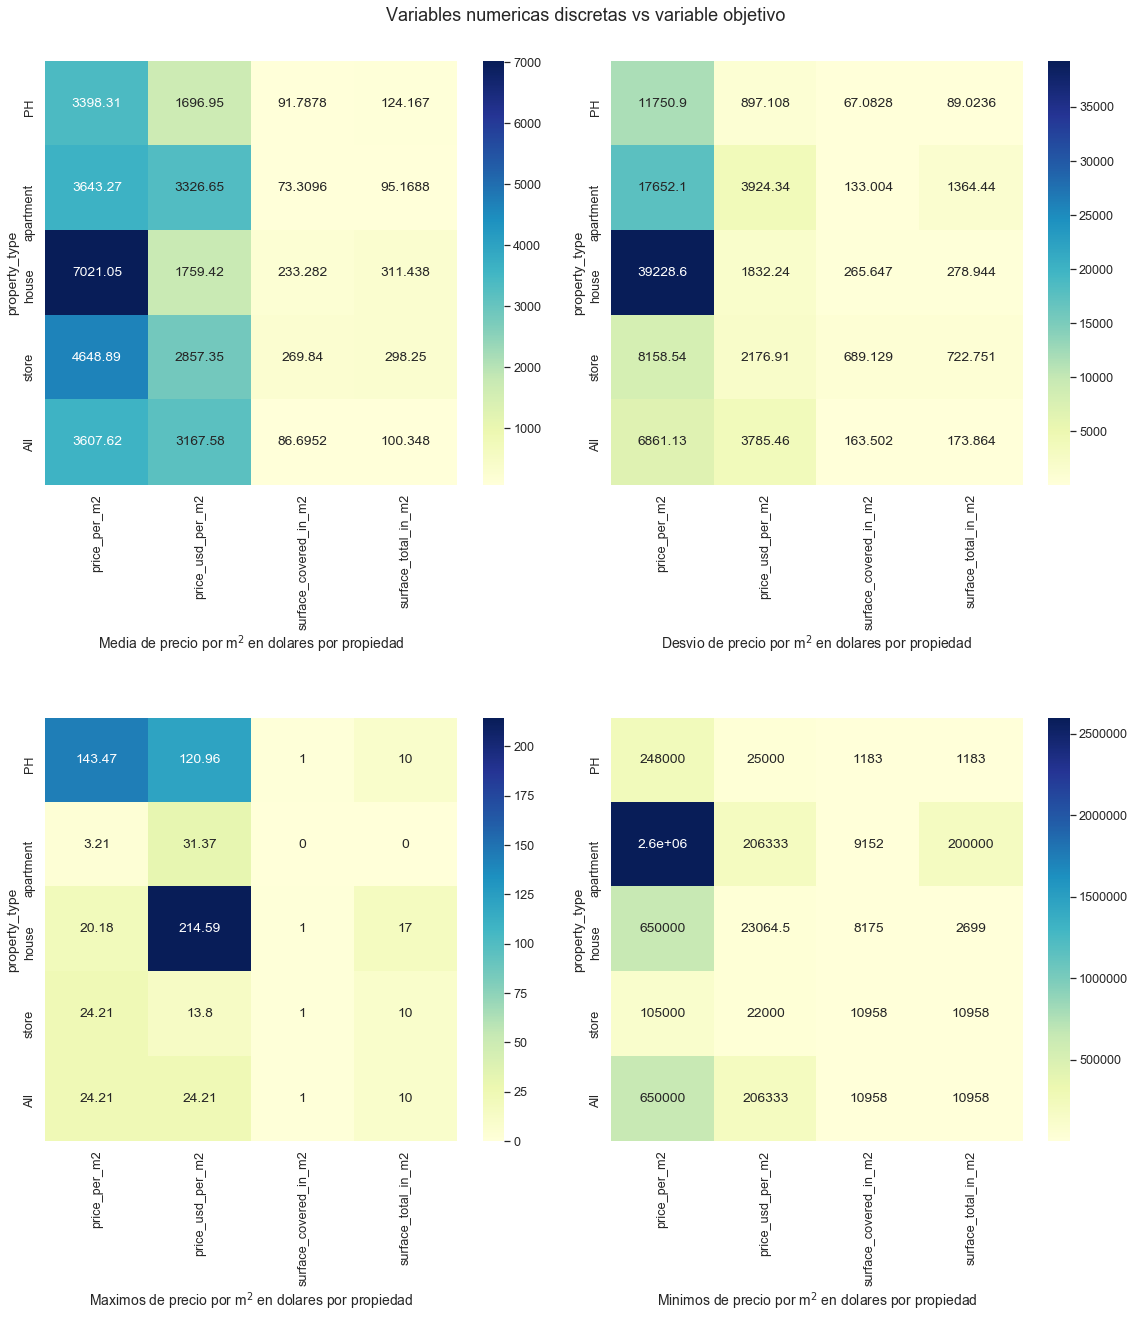

In [36]:
fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Variables numericas discretas vs variable objetivo', y=1.05, fontsize=18)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.55)

sns.heatmap(cont_prop_mean, annot=True, fmt='g', cmap='YlGnBu', ax=axs[0,0]);
axs[0,0].set_xlabel('Media de precio por m$^2$ en dolares por propiedad', fontsize=14)

sns.heatmap(cont_prop_std, annot=True, fmt='g', cmap='YlGnBu', ax=axs[0,1]);
axs[0,1].set_xlabel('Desvio de precio por m$^2$ en dolares por propiedad', fontsize=14)

sns.heatmap(cont_prop_max, annot=True, fmt='g', cmap='YlGnBu', ax=axs[1,0]);
axs[1,0].set_xlabel('Maximos de precio por m$^2$ en dolares por propiedad', fontsize=14)

sns.heatmap(cont_prop_min, annot=True, fmt='g', cmap='YlGnBu', ax=axs[1,1]);
axs[1,1].set_xlabel('Minimos de precio por m$^2$ en dolares por propiedad', fontsize=14)


plt.show()

In [37]:
sf_usd_vs = data.loc[:, ['price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2']]

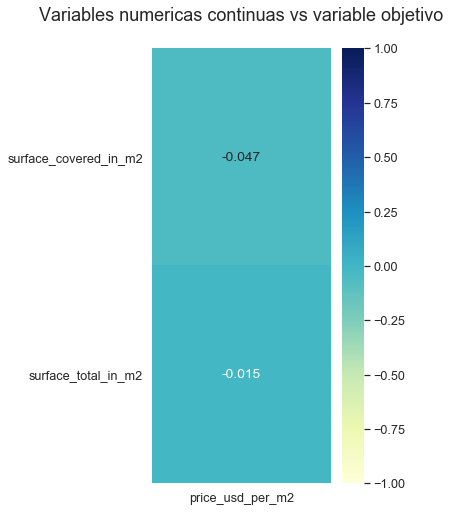

In [38]:
fig = plt.figure(figsize=(4, 8))
plt.title('Variables numericas continuas vs variable objetivo', y=1.05, fontsize=18)

yticks = sf_usd_vs.columns[1:]

sns.heatmap(sf_usd_vs.corr().iloc[1:,0].to_frame().sort_values(by='price_usd_per_m2'), annot=True,vmin=-1, yticklabels=yticks, vmax=1, cmap='YlGnBu');

plt.yticks(rotation=0) 

plt.show()

### Correlacion entre variables numericas discretas con respecto a la variable target.

#### La variable objetivo

In [39]:
m2_usd_vs = data.loc[:, ['price_usd_per_m2', 'cochera', 'piscina', 'parrilla', 'baulera', 'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad', 'metrobus']].corr()
pt_usd_vs = data.loc[:, ['price_usd_per_m2', 'property_type']]

In [40]:
pt_usd_vs = pd.get_dummies(data.property_type)
pt_usd_vs = pt_usd_vs.join(data.loc[:, 'price_usd_per_m2'])

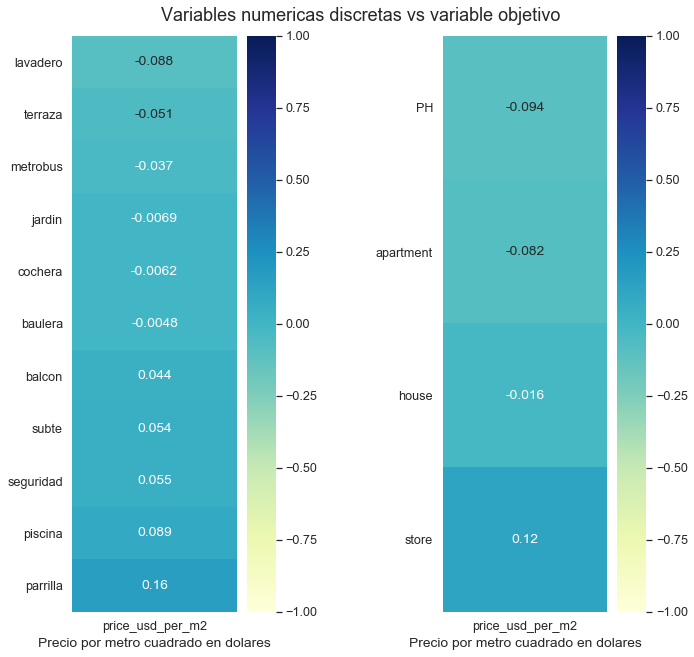

In [41]:
fig, axs = plt.subplots(1,2,figsize=(8,8))
fig.suptitle('Variables numericas discretas vs variable objetivo', y=1.05, fontsize=18)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.8, hspace=0.2)

yticks = pt_usd_vs.columns[:-1]

sns.heatmap(m2_usd_vs.iloc[1:,0].to_frame().sort_values(by='price_usd_per_m2'), annot=True,vmin=-1, vmax=1, cmap='YlGnBu', ax=axs[0]);
axs[0].set(xlabel='Precio por metro cuadrado en dolares')

sns.heatmap(pt_usd_vs.corr().iloc[:-1,-1].to_frame().sort_values(by='price_usd_per_m2'), annot=True,vmin=-1, vmax=1, cmap='YlGnBu', yticklabels=yticks, ax=axs[1]);
axs[1].set(xlabel='Precio por metro cuadrado en dolares')

plt.yticks(rotation=0) 

plt.show()

---

## Outliers

### Removedor de outliers

 Para ejecutar el proceso de remocion de outliers en aquellas variables numericas continuas, se diseño una funcion denominada `remove_outlier()` que se encarga de ajustar los valores extremos de acuerdo a dos parametros de filtro. Ademas es posible aplicar diferentes parametros como la varible objetivo a aplicar los filtros, los margenes considerados outliers, o los cuantiles.

In [42]:
def remove_outlier(df_in, qt1, qt3, iqrout, col_name, mask1, var1, mask2=None, var2=None):
    '''
    Calculo de outliers

    Parameters
    ----------
    df_in : dataFrame
        dataFrame utilizado para extraer variables de filtro y mascaras.
    qt1, qt3: float
        Cuantil inferior y superior (0 a 1).
    iqrout: float
        Margen exterior a iqr (1.5 o 3 recomendado)
    var1, var2: str
        Nombre de columnas de dataFrame ingresado como parametro para aplicar filtro sobre los datos.
    mask1, mask2: str
        Valores para utilizar con las columnas de filtro para generar mascaras booleanas.
    col_name: str
        Variable a aplicar los outliers.
    
    Output
    ------
    dataFrame filtrado por parametros con los outliers aplicados.

    Example
    ----------
    remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', 'Belgrano', 'place_name', 'PH', 'property_type')
    
    '''
    
    if (mask2 is None and var2 is not None) | (mask2 is not None and var2 is None):
        return 'you must set second mask with second variable'
    elif mask2 is None and var2 is None:
        var_mask = df_in[var1] == mask1
    else:
        var_mask = (df_in[var1] == mask1) & (df_in[var2] == mask2)
        
    q1 = df_in.loc[var_mask, col_name].quantile(qt1)
    q3 = df_in.loc[var_mask, col_name].quantile(qt3)
    
    iqr = q3-q1 #Interquartile range
    
    fence_low  = q1-iqrout*iqr
    fence_high = q3+iqrout*iqr
    
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high) & var_mask]
    
    return df_out

#### Primer pasada remocion de outliers variable objetivo

In [43]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        #df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_temp = remove_outlier(data.loc[data.price_usd_per_m2.notnull(), :], 0.25, 0.75, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [44]:
df_final = df_final.append(data.loc[data.price_usd_per_m2.isnull(), :])
data = df_final

#### Primer pasada remocion variable `surface_total_in_m2`

In [45]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        #df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'surface_total_in_m2', pn, 'place_name', pt, 'property_type')
        df_temp = remove_outlier(data.loc[data.surface_total_in_m2.notnull(), :], 0.25, 0.75, 1.5, 'surface_total_in_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [46]:
df_final = df_final.append(data.loc[data.surface_total_in_m2.isnull(), :])
data = df_final

#### Resultado preliminar

In [47]:
data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2']].corr()

,price_aprox_usd,price_usd_per_m2,surface_covered_in_m2,surface_total_in_m2,price_per_m2
price_aprox_usd,1.000000,0.427004,0.394695,0.554724,0.144343
price_usd_per_m2,0.427004,1.000000,-0.061702,-0.087623,0.437772
surface_covered_in_m2,0.394695,-0.061702,1.000000,0.798168,-0.035994
surface_total_in_m2,0.554724,-0.087623,0.798168,1.000000,-0.001769
price_per_m2,0.144343,0.437772,-0.035994,-0.001769,1.000000


### Analisis de distribucion por barrio

In [48]:
precio_m2_barrio = data.groupby(['place_name','property_type']).agg({'price_usd_per_m2':  ['max']})
display(precio_m2_barrio.shape)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2', 'max')], ascending=False).head(20))

(222, 1)

,,price_usd_per_m2
,,max
place_name,property_type,
Boedo,apartment,34608.00
San Cristobal,apartment,26241.64
Boedo,house,20784.21
Puerto Madero,apartment,9000.00
Palermo,store,8900.00
Palermo Chico,store,8536.59
Recoleta,store,8163.27
Puerto Madero,store,7857.14


#### Distribucion de precios barrio de Boedo

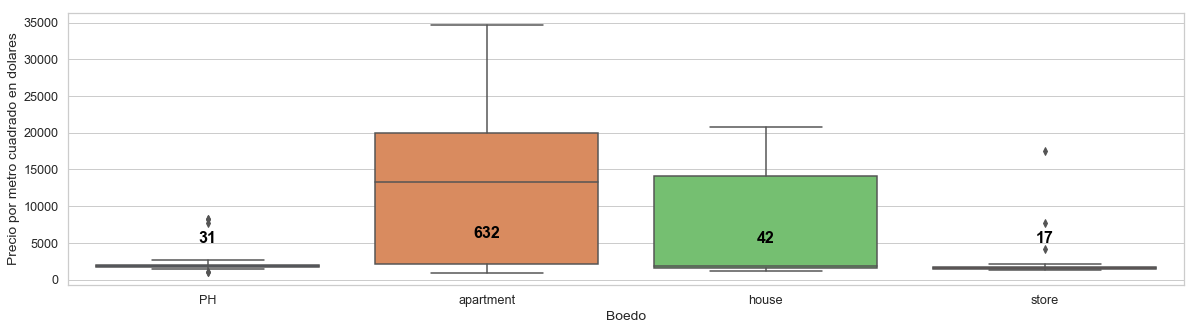

In [49]:
plt.subplots(figsize=(20,5))
mask_place_name = data.place_name == 'Boedo'
g = sns.boxplot(x='property_type',y='price_per_m2',data=data.loc[mask_place_name, :], palette='muted')
g.set(xlabel='Boedo', ylabel='Precio por metro cuadrado en dolares')

valores = data.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 5000

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

plt.show()

**Distribucion de precios barrio de Boedo: Outliers sobre departamentos**

In [50]:
df_final = pd.DataFrame()
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'apartment'
place_name_list = data.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  data.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

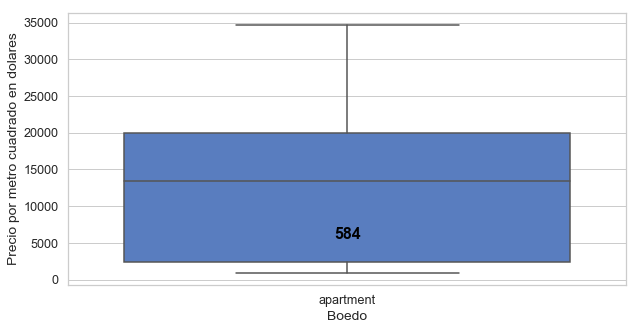

In [51]:
plt.subplots(figsize=(10,5))
mask_place_name = df_final.place_name == 'Boedo'
g = sns.boxplot(x='property_type',y='price_per_m2',data=df_final.loc[mask_place_name, :], palette='muted')
g.set(xlabel='Boedo', ylabel='Precio por metro cuadrado en dolares')

valores = df_final.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 5000

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

plt.show()

**Distribucion de precios barrio de Boedo: Outliers sobre departamentos**

Aplicacion de tope maximo segun estimaciones de mercado

In [52]:
df_final1 = pd.DataFrame()
mask_precio_max = df_final.price_usd_per_m2 < 3500
mask_place_name = df_final.place_name == 'Boedo'
mask_property_type = df_final.property_type == 'apartment'
place_name_list = df_final.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  df_final.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(df_final.loc[mask_precio_max], 0.10, 0.90, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final1 = df_final1.append(df_temp)

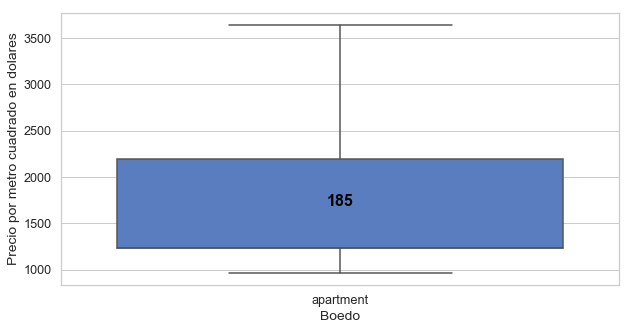

In [53]:
plt.subplots(figsize=(10,5))
mask_place_name = df_final1.place_name == 'Boedo'
g = sns.boxplot(x='property_type',y='price_per_m2',data=df_final1.loc[mask_place_name, :], palette='muted')
g.set(xlabel='Boedo', ylabel='Precio por metro cuadrado en dolares')

valores = df_final1.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 1500

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

plt.show()

In [54]:
precio_m2_barrio_Boedo = df_final1.loc[:,['price_usd_per_m2','Id_caso']]
display(precio_m2_barrio_Boedo.shape)
display(precio_m2_barrio_Boedo.sort_values(by = [('price_usd_per_m2')], ascending=False).head(10))

(185, 2)

,price_usd_per_m2,Id_caso
5736,3340.00,25668
5750,3337.14,25684
5730,3337.14,25661
5773,3244.57,25708
25364,3014.10,105347
25362,3014.10,105336
25356,2877.89,105298
25358,2861.87,105308
25368,2843.99,105362
25359,2708.30,105319


In [55]:
# borro todos los de Boedo / Departamento
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'apartment'
data = data.drop(data.loc[mask_place_name&mask_property_type].index)

In [56]:
# append todos los de Boedo / Departamento nuevos (sin outliers)
data = data.append(df_final1)

In [57]:
# valido
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'apartment'
data.loc[mask_place_name&mask_property_type]

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero,subte,seguridad,metrobus
23,66,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6187769485,-58.4026450688",-34.618777,-58.402645,72900.0,USD,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0
1028,6482,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6234762,-58.4121858",-34.623476,-58.412186,75000.0,USD,...,1.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
2536,12682,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,73000.0,USD,...,1.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
4544,21552,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6277173,-58.4318588",-34.627717,-58.431859,45000.0,USD,...,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
5318,24887,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6233498,-58.4205356",-34.623350,-58.420536,74000.0,USD,...,0.0,1.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
5555,25430,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6270872,-58.4201308",-34.627087,-58.420131,72000.0,USD,...,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0
5566,25447,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,30100.0,USD,...,1.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
5572,25457,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,30100.0,USD,...,1.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
5575,25463,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,30200.0,USD,...,1.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
5578,25470,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,30200.0,USD,...,1.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0


In [58]:
# Borro grafico de distribucion de precios boedo casa - redundante ya que esta arriba

**Distribucion de precios barrio de Boedo: Outliers sobre casas**

Aplicacion de tope maximo segun estimaciones de mercado

In [59]:
# Distribucion precios Bodeo Casa

df_final = pd.DataFrame()
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'house'
place_name_list = data.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  data.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [60]:
precio_m2_barrio = df_final.loc[:,['price_usd_per_m2','Id_caso']]
display(precio_m2_barrio)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2')], ascending=False).head(10))

,price_usd_per_m2,Id_caso
15,1091.27,51
3596,1649.48,17392
3756,1550.39,18013
3881,909.09,18524
5194,1065.22,24532
5467,880.95,25192
5468,1184.21,25193
5651,15176.67,25562
5652,14520.00,25563
5653,14093.33,25564


,price_usd_per_m2,Id_caso
6426,20784.21,26599
6404,20784.21,26555
6467,17906.06,26702
6469,17903.03,26704
5658,15196.67,25571
5651,15176.67,25562
5652,14520.00,25563
5653,14093.33,25564
11570,1946.15,47937
8478,1944.44,35735


In [61]:
df_final1 = pd.DataFrame()
mask_precio_max = df_final.price_usd_per_m2 < 10000
mask_place_name = df_final.place_name == 'Boedo'
mask_property_type = df_final.property_type == 'house'
place_name_list = df_final.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  df_final.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(df_final.loc[mask_precio_max], 0.10, 0.90, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final1 = df_final1.append(df_temp)

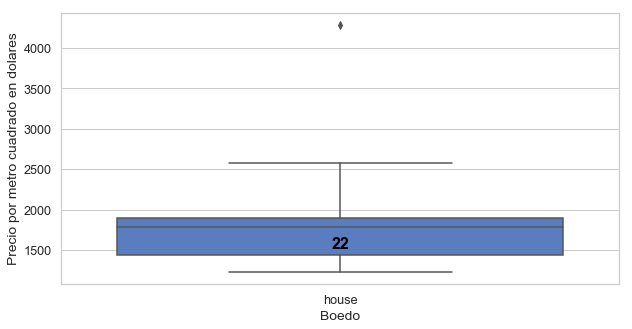

In [62]:
plt.subplots(figsize=(10,5))
mask_place_name = df_final1.place_name == 'Boedo'
g = sns.boxplot(x='property_type',y='price_per_m2',data=df_final1.loc[mask_place_name, :], palette='muted')
g.set(xlabel='Boedo', ylabel='Precio por metro cuadrado en dolares')

valores = df_final1.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 1500

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

plt.show()

In [63]:
# Borro grafico de distribucion de precios Boedo Casa - 2ra pasada outliers - df_final1

In [64]:
precio_m2_barrio = df_final1.loc[:,['price_usd_per_m2','Id_caso']]
display(precio_m2_barrio.shape)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2')], ascending=False))


(22, 2)

,price_usd_per_m2,Id_caso
11570,1946.15,47937
8478,1944.44,35735
14233,1892.86,57976
13347,1822.43,55048
6420,1774.19,26591
6450,1774.19,26634
3596,1649.48,17392
25388,1596.64,105586
3756,1550.39,18013
13471,1436.57,55281


In [65]:
# borro todos los de Boedo / Casa
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'house'
data = data.drop(data.loc[mask_place_name&mask_property_type].index)

In [66]:
# append todos los de Boedo / Casa nuevos (sin outliers)
data = data.append(df_final1)

In [67]:
# valido
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'house'
data.loc[mask_place_name&mask_property_type]

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero,subte,seguridad,metrobus
15,51,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6363209,-58.4107019",-34.636321,-58.410702,550000.0,USD,...,1.0,1.0,0.0,0,1.0,1.0,1.0,0.0,0.0,0.0
3596,17392,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.620767,-58.4141356",-34.620767,-58.414136,800000.0,USD,...,0.0,0.0,0.0,0,0.0,1.0,1.0,0.0,0.0,0.0
3756,18013,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6328351,-58.4144969",-34.632835,-58.414497,400000.0,USD,...,0.0,0.0,0.0,0,0.0,1.0,1.0,0.0,0.0,0.0
3881,18524,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6223456,-58.4229163",-34.622346,-58.422916,300000.0,USD,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
5194,24532,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6292035,-58.4118558",-34.629203,-58.411856,245000.0,USD,...,0.0,0.0,0.0,0,1.0,0.0,1.0,0.0,0.0,0.0
5467,25192,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6342606,-58.4178509",-34.634261,-58.417851,370000.0,USD,...,0.0,0.0,0.0,0,1.0,1.0,1.0,0.0,0.0,0.0
5468,25193,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6314763,-58.4165521",-34.631476,-58.416552,450000.0,USD,...,0.0,1.0,0.0,1,1.0,0.0,1.0,0.0,0.0,0.0
6146,26187,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,37000.0,USD,...,1.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
6316,26391,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,40000.0,USD,...,1.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
6420,26591,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6209899,-58.4165467",-34.620990,-58.416547,55000.0,USD,...,1.0,1.0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0


#### Distribucion de precios barrio de San Cristobal

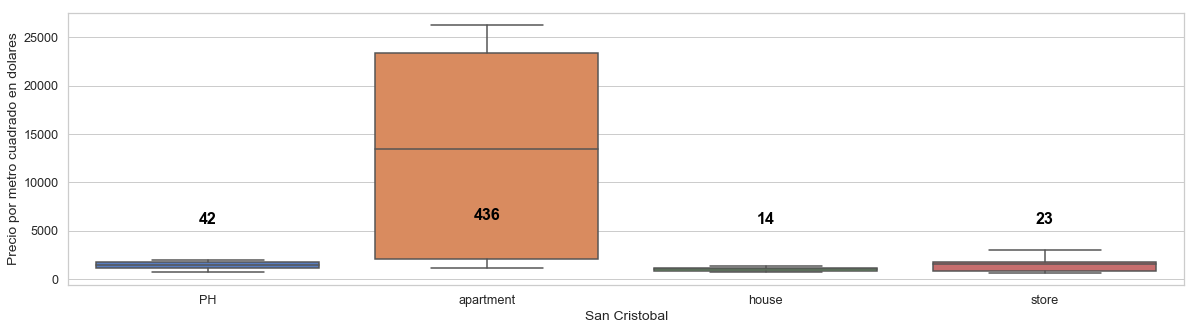

In [68]:
mask_place_name = data.place_name == 'San Cristobal'

plt.subplots(figsize=(20,5))
g = sns.boxplot(x='property_type',y='price_usd_per_m2',data=data.loc[mask_place_name, :],palette='muted')
g.set(xlabel='San Cristobal', ylabel='Precio por metro cuadrado en dolares')

valores = data.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 5700

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

In [69]:
df_final = pd.DataFrame()
mask_place_name = data.place_name == 'San Cristobal'
mask_property_type = data.property_type == 'apartment'
place_name_list = data.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  data.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

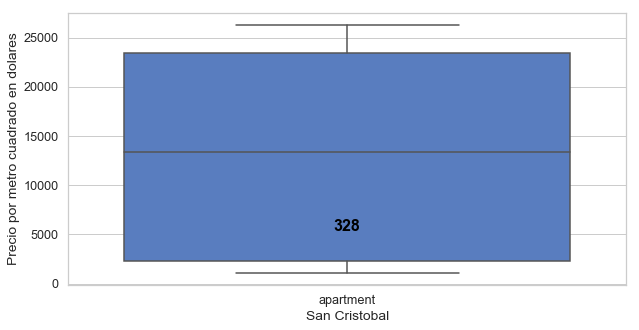

In [70]:
plt.subplots(figsize=(10,5))
mask_place_name = df_final.place_name == 'San Cristobal'
g = sns.boxplot(x='property_type',y='price_per_m2',data=df_final.loc[mask_place_name, :], palette='muted')
g.set(xlabel='San Cristobal', ylabel='Precio por metro cuadrado en dolares')

valores = df_final.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 5000

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

plt.show()

In [71]:
precio_m2_barrio = df_final.loc[:,['price_usd_per_m2','Id_caso']]
display(precio_m2_barrio.shape)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2')], ascending=False).head(10))

(328, 2)

,price_usd_per_m2,Id_caso
6320,26241.64,26396
6274,26136.36,26339
6214,26018.97,26270
6232,25991.55,26291
6125,25967.09,26161
6304,25956.88,26379
6174,25900.73,26216
6098,25899.70,26123
6369,25896.09,26505
6242,25896.09,26302


SEGUN LAS url XXXXX se indica que el precio maximo promedio de metro cuadrado en dolares para el barrio XXXX es de XXXXX, por lo que se decido colocar un tope de precio maximo de 3500 dolares

In [72]:
df_final1 = pd.DataFrame()
mask_precio_max = df_final.price_usd_per_m2 < 3500
mask_place_name = df_final.place_name == 'San Cristobal'
mask_property_type = df_final.property_type == 'apartment'
place_name_list = df_final.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  df_final.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(df_final.loc[mask_precio_max], 0.10, 0.90, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final1 = df_final1.append(df_temp)

In [73]:
# Borro grafico de distribucion de precios San Cristobal apartamento - 2ra pasada outliers - df_final1

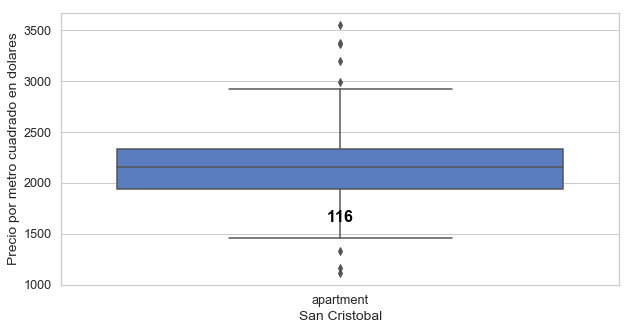

In [74]:
plt.subplots(figsize=(10,5))
mask_place_name = df_final1.place_name == 'San Cristobal'
g = sns.boxplot(x='property_type',y='price_per_m2',data=df_final1.loc[mask_place_name, :], palette='muted')
g.set(xlabel='San Cristobal', ylabel='Precio por metro cuadrado en dolares')

valores = df_final1.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 1500

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

plt.show()

In [75]:
precio_m2_barrio = df_final1.loc[:,['price_usd_per_m2','Id_caso']]
display(precio_m2_barrio.shape)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2')], ascending=False).head(10))

(116, 2)

,price_usd_per_m2,Id_caso
27626,3142.86,114468
10829,3125.00,45002
19629,3121.95,79116
5729,2995.00,25660
1013,2962.96,6433
5757,2840.00,25691
5761,2782.50,25695
6592,2651.16,27131
9582,2612.50,39777
23660,2500.00,95003


In [76]:
# borro todos los de San Cristobal / Departamento
mask_place_name = data.place_name == 'San Cristobal'
mask_property_type = data.property_type == 'apartment'
data = data.drop(data.loc[mask_place_name&mask_property_type].index)

In [77]:
# append todos los de San Cristobal / Departamento nuevos (sin outliers)
data = data.append(df_final1)

In [78]:
# valido
mask_place_name = data.place_name == 'San Cristobal'
mask_property_type = data.property_type == 'apartment'
display(data.loc[mask_place_name&mask_property_type].head(3))
display(data.loc[mask_place_name&mask_property_type].shape)

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero,subte,seguridad,metrobus
315,1532,apartment,|Argentina|Capital Federal|San Cristobal|,Argentina,Capital Federal,"-34.618949,-58.3944713",-34.618949,-58.394471,80000.0,USD,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1013,6433,apartment,|Argentina|Capital Federal|San Cristobal|,Argentina,Capital Federal,"-34.6236285,-58.4059861",-34.623628,-58.405986,160000.0,USD,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1518,8184,apartment,|Argentina|Capital Federal|San Cristobal|,Argentina,Capital Federal,"-34.6244262,-58.3973636",-34.624426,-58.397364,71000.0,USD,...,0.0,1.0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0


(116, 39)

In [79]:
#+++++++++++++++++++++++++++++++
#validacion general
#++++++++++++++++++++++++++++++++

precio_m2_barrio = data.groupby(['place_name','property_type']).agg({'price_usd_per_m2':  ['max']})
display(precio_m2_barrio.shape)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2', 'max')], ascending=False).head(10))


(222, 1)

,,price_usd_per_m2
,,max
place_name,property_type,
Puerto Madero,apartment,9000.00
Palermo,store,8900.00
Palermo Chico,store,8536.59
Recoleta,store,8163.27
Puerto Madero,store,7857.14
Once,store,7692.31
Palermo Chico,apartment,7304.35
Villa Crespo,store,7083.33


In [80]:
data.shape

(25884, 39)

In [81]:
#list(data.columns)

---

### Imputaciones

Caracteristicas:

Variables a imputar: `surface_covered_in_m2`, `surface_total_in_m2`, `price_usd_per_m2`, `price_per_m2`

Imputacion por mediana, segmentado por barrio y tipo de propiedad.

Criterio de imputacion:
 * Para que se aplique la imputacion el porcentaje de nulos por barrio menor al 25% 
 * Desvio estandar menor o igual a la mitad de la mediana del desvio estandar del tipo de propiedad por barrio.
   
Se busca garantizar la maxima representatibidad de los datos a imputar.

In [82]:
#display(data.surface_covered_in_m2.isnull().value_counts())
#display(data.price_per_m2.isnull().value_counts())

display(data.surface_total_in_m2.isnull().value_counts())
display(data.price_usd_per_m2.isnull().value_counts())

False    22340
True      3544
Name: surface_total_in_m2, dtype: int64

False    19250
True      6634
Name: price_usd_per_m2, dtype: int64

In [83]:
# Nulos de precio y superficie para revisar imputacion

price_usd_per_m2_null = data.price_usd_per_m2.isnull()
surface_total_in_m2_null = data.surface_total_in_m2.isnull()
surface_covered_in_m2_null = data.surface_covered_in_m2.isnull()
price_per_m2_null = data.price_per_m2.isnull()

In [84]:
#nulos = price_usd_per_m2_null | surface_total_in_m2_null | surface_covered_in_m2_null | price_per_m2_null

nulos = price_usd_per_m2_null | surface_total_in_m2_null

dfimp = data.loc[nulos, ['Id_caso', 'place_name', 'property_type', 'price_usd_per_m2','price_per_m2','surface_total_in_m2','surface_covered_in_m2']]
dfimp.set_index("Id_caso", inplace = True)

display(dfimp.sample(3))
display(dfimp.shape)

,place_name,property_type,price_usd_per_m2,price_per_m2,surface_total_in_m2,surface_covered_in_m2
Id_caso,,,,,,
108251,Villa Crespo,apartment,NaN,3555.56,NaN,36.0
49410,Nuñez,apartment,NaN,NaN,NaN,NaN
56812,Recoleta,apartment,NaN,2018.35,86.0,109.0


(6634, 6)

In [85]:
#dfimp.price_usd_per_m2.isnull().value_counts()
#dfimp.surface_total_in_m2.isnull().value_counts()
#dfimp.loc[:, "place_name"].value_counts()

Identificamos los nulos sobre el dataframe de nulos generado

In [86]:
#display(dfimp.price_per_m2.isnull().value_counts())
#display(dfimp.surface_covered_in_m2.isnull().value_counts())

display(dfimp.price_usd_per_m2.isnull().value_counts())
display(dfimp.surface_total_in_m2.isnull().value_counts())

True    6634
Name: price_usd_per_m2, dtype: int64

True     3544
False    3090
Name: surface_total_in_m2, dtype: int64

Comprobacion de valores

In [87]:
display(dfimp.loc[(dfimp.property_type == 'PH') & (dfimp.place_name =='San Telmo'), 'price_usd_per_m2'])
display(dfimp.loc[(dfimp.property_type == 'apartment') & (dfimp.place_name =='Abasto'), 'price_usd_per_m2'].head(5))

Id_caso
18834   NaN
53675   NaN
56539   NaN
Name: price_usd_per_m2, dtype: float64

Id_caso
45087   NaN
45787   NaN
47762   NaN
47763   NaN
78447   NaN
Name: price_usd_per_m2, dtype: float64

Calculo de cantidad de nulos de precio por barrio

In [88]:
data_porc_nulos = pd.DataFrame(dfimp["place_name"].value_counts()) # todos los nulos de precio en dfimp son de price_usd_per_m2
data_porc_nulos.rename(columns = {"place_name":"nulos"}, inplace = True)
data_porc_todos = pd.DataFrame(data.place_name.value_counts())

data_porc = pd.concat([data_porc_nulos, data_porc_todos], axis = 1)
data_porc["porc"] = (data_porc.nulos/data_porc.place_name * 100).round(2)
data_porc.rename(columns = {"place_name":"total"}, inplace = True)
data_porc.sort_values(by = ["porc"], ascending=True).head(30)

,nulos,total,porc
Boedo,11,255,4.31
Palermo Viejo,3,35,8.57
Las Cañitas,13,126,10.32
Palermo Hollywood,46,425,10.82
Parque Centenario,6,55,10.91
Villa Ortuzar,9,77,11.69
San Telmo,114,927,12.30
Centro / Microcentro,29,193,15.03
Chacarita,27,179,15.08
Barracas,59,372,15.86


**Proceso imputacion variables numericas continuas**

 Proceso de imputacion segregado en tipo de propiedad y barrio. El proceso imputa por la mediana en el caso de que el porcentaje de nulos para el barrio sea menor al 25% y que el desbio por barrio sea un 10% mayor a la mediana de los desvios.



In [89]:
# col_imputacion = ['price_usd_per_m2','price_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2']

col_imputacion = ['price_usd_per_m2','surface_total_in_m2']

for c in col_imputacion:
    for b in data.place_name.unique():
        for p in list(data.loc[data.place_name == b, 'property_type'].value_counts().index):
            barrio_prop_imp = data.loc[data.property_type == p, :].groupby('place_name')[c]
            if (data_porc.loc[data_porc.index == b, 'porc'][0] <= 25.00) & (barrio_prop_imp.std()[b] < barrio_prop_imp.std().median() * 1.1): # mediana de desvios
                
                nulos = dfimp[c].isnull()
                barrio = dfimp.place_name == b
                propiedad = dfimp.property_type == p
                dfimp.loc[nulos & barrio & propiedad, c] = barrio_prop_imp.median()[b]

In [90]:
#display(dfimp.price_per_m2.isnull().value_counts())
#display(dfimp.surface_covered_in_m2.isnull().value_counts())

display(dfimp.price_usd_per_m2.isnull().value_counts())
display(dfimp.surface_total_in_m2.isnull().value_counts())

True     5509
False    1125
Name: price_usd_per_m2, dtype: int64

False    3463
True     3171
Name: surface_total_in_m2, dtype: int64

In [91]:
display(dfimp.loc[(dfimp.property_type == 'PH') & (dfimp.place_name =='San Telmo'), 'price_usd_per_m2'])
display(dfimp.loc[(dfimp.property_type == 'apartment') & (dfimp.place_name =='Abasto'), 'price_usd_per_m2'])

Id_caso
18834    1420.77
53675    1420.77
56539    1420.77
Name: price_usd_per_m2, dtype: float64

Id_caso
45087     2330.07
45787     2330.07
47762     2330.07
47763     2330.07
78447     2330.07
87483     2330.07
109713    2330.07
12842     2330.07
25298     2330.07
44340     2330.07
52901     2330.07
59549     2330.07
71972     2330.07
71990     2330.07
109769    2330.07
Name: price_usd_per_m2, dtype: float64

In [92]:
dfimp

,place_name,property_type,price_usd_per_m2,price_per_m2,surface_total_in_m2,surface_covered_in_m2
Id_caso,,,,,,
7137,Mataderos,PH,NaN,NaN,90.00,74.0
8628,Mataderos,PH,NaN,3600.00,100.00,20.0
9588,Mataderos,PH,NaN,2900.00,26.00,20.0
18427,Mataderos,PH,NaN,11000.00,87.15,20.0
28110,Mataderos,PH,NaN,2837.84,45.00,37.0
...,...,...,...,...,...,...
121148,Flores,PH,NaN,1237.84,NaN,185.0
121149,Caballito,house,NaN,2487.18,220.00,195.0
121150,Paternal,apartment,NaN,1826.92,NaN,52.0


In [93]:
# armamos df con los valores imputados para concatenar al data original

data.set_index("Id_caso", inplace = True)

# dfimp - 'price_usd_per_m2'
dfimp_price_usd_per_m2 = dfimp.drop(['place_name','property_type','price_per_m2','surface_total_in_m2','surface_covered_in_m2' ],axis=1)
dfimp_price_usd_per_m2.rename(columns = {'price_usd_per_m2': 'price_usd_per_m2_imputado'}, inplace=True)
data_imputac = pd.concat([data, dfimp_price_usd_per_m2], axis = 1)

# dfimp - 'surface_total_in_m2'
dfimp_surface_total_in_m2 = dfimp.drop(['place_name','property_type', 'price_usd_per_m2','price_per_m2','surface_covered_in_m2'],axis=1)
dfimp_surface_total_in_m2.rename(columns = {'surface_total_in_m2': 'surface_total_in_m2_imputado'}, inplace=True)
data_imputac = pd.concat([data_imputac, dfimp_surface_total_in_m2], axis = 1)


# dfimp - 'price_per_m2'
#dfimp_price_per_m2 = dfimp.drop(['place_name','property_type', 'price_usd_per_m2','surface_total_in_m2','surface_covered_in_m2'],axis=1)
#dfimp_price_per_m2.rename(columns = {'price_per_m2': 'price_per_m2_imputado'}, inplace=True)
#data_imputac = pd.concat([data, dfimp_price_per_m2], axis = 1)

# dfimp - 'surface_covered_in_m2'
#dfimp_surface_covered_in_m2 = dfimp.drop(['place_name','property_type', 'price_usd_per_m2','price_per_m2', 'surface_total_in_m2'],axis=1)
#dfimp_surface_covered_in_m2.rename(columns = {'surface_covered_in_m2': 'surface_covered_in_m2_imputado'}, inplace=True)
#data_imputac = pd.concat([data, dfimp_surface_covered_in_m2], axis = 1)
#data_imputac.drop(['surface_covered_in_m2_imputado'],axis=1, inplace=True)

Comprobacion de imputacion

In [94]:
display(data_imputac.loc[18834, 'surface_total_in_m2_imputado'])
display(data_imputac.loc[8226, 'price_usd_per_m2_imputado'])

100.0

2365.69

In [95]:
# imputamos las columnas de precio:

price_usd_per_m2_null = data_imputac.price_usd_per_m2.isnull()
data_imputac.loc[price_usd_per_m2_null, "price_usd_per_m2"] = data_imputac.loc[price_usd_per_m2_null, "price_usd_per_m2_imputado"]

In [96]:
data = data_imputac.reset_index()

In [97]:
data_imputac.loc[18834, 'price_usd_per_m2']
data.loc[data.Id_caso == 18834, 'price_usd_per_m2']

3427    1420.77
Name: price_usd_per_m2, dtype: float64

In [98]:
data.columns

Index(['Id_caso', 'property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad',
       'metrobus', 'price_usd_per_m2_imputado',
       'surface_total_in_m2_imputado'],
      dtype='object')

In [99]:
data.shape

(25884, 41)

## Correlaciones entre variables luego de aplicacion de Outliers e imputaciones

### Correlacion entre variables numericas continuas con respecto a la variable target.

In [100]:
data_numericas_continuas = data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2']]

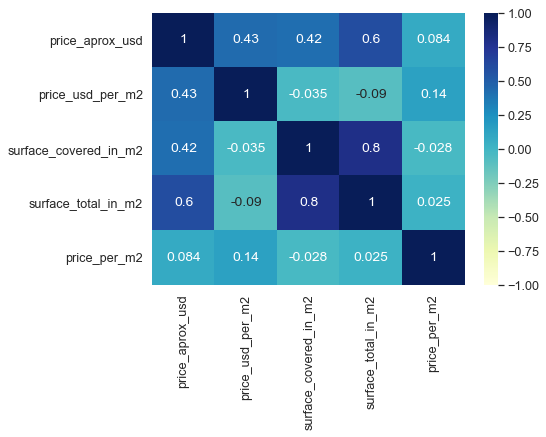

In [101]:
fig, ax = plt.subplots(figsize=(7,5))
g = sns.heatmap(data_numericas_continuas.corr(), annot=True, vmin=-1, vmax=1, cmap="YlGnBu")

#### Relaciones basicas entre variables numericas continuas:
 * Media.
 * Desvio estandar.
 * Maximos.
 * Minimos.

In [102]:
data_hm = data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2', 'property_type']]
cont_prop_mean = pd.pivot_table(data_hm, values=['price_usd_per_m2', 'price_per_m2','surface_covered_in_m2', 'surface_total_in_m2'], index='property_type', aggfunc=np.mean, margins = True)
cont_prop_std = pd.pivot_table(data_hm, values=['price_usd_per_m2', 'price_per_m2','surface_covered_in_m2', 'surface_total_in_m2'], index='property_type', aggfunc=np.std, margins = True)
cont_prop_max = pd.pivot_table(data_hm, values=['price_usd_per_m2', 'price_per_m2','surface_covered_in_m2', 'surface_total_in_m2'], index='property_type', aggfunc=np.min, margins = True)
cont_prop_min = pd.pivot_table(data_hm, values=['price_usd_per_m2', 'price_per_m2','surface_covered_in_m2', 'surface_total_in_m2'], index='property_type', aggfunc=np.max, margins = True)

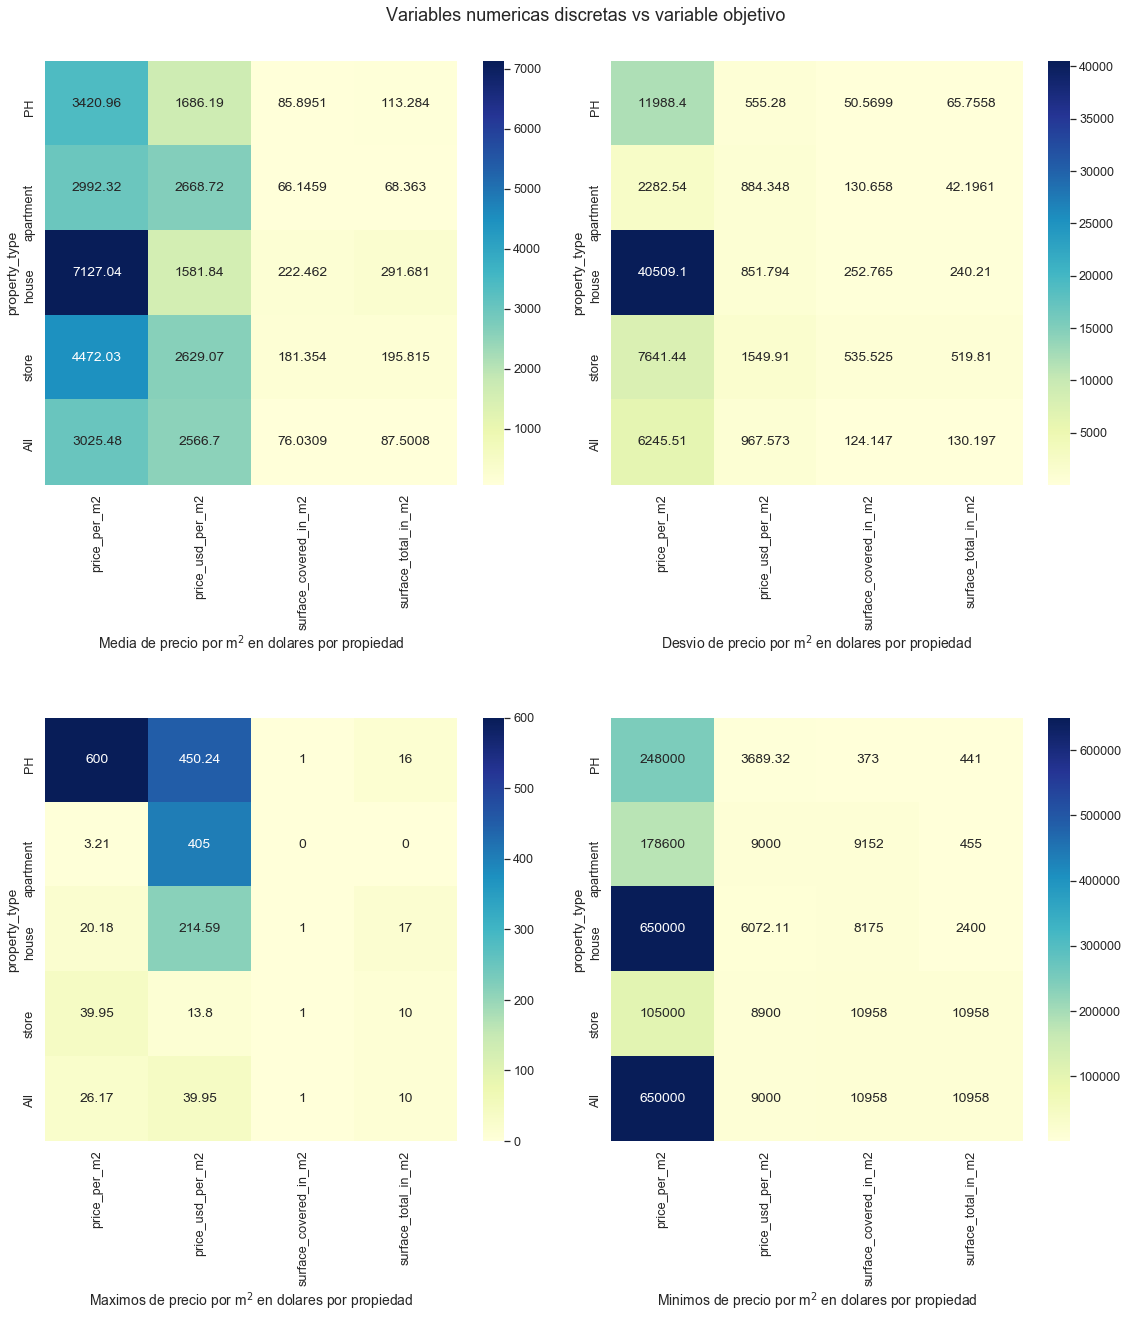

In [103]:
fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Variables numericas discretas vs variable objetivo', y=1.05, fontsize=18)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.55)

sns.heatmap(cont_prop_mean, annot=True, fmt='g', cmap='YlGnBu', ax=axs[0,0]);
axs[0,0].set_xlabel('Media de precio por m$^2$ en dolares por propiedad', fontsize=14)

sns.heatmap(cont_prop_std, annot=True, fmt='g', cmap='YlGnBu', ax=axs[0,1]);
axs[0,1].set_xlabel('Desvio de precio por m$^2$ en dolares por propiedad', fontsize=14)

sns.heatmap(cont_prop_max, annot=True, fmt='g', cmap='YlGnBu', ax=axs[1,0]);
axs[1,0].set_xlabel('Maximos de precio por m$^2$ en dolares por propiedad', fontsize=14)

sns.heatmap(cont_prop_min, annot=True, fmt='g', cmap='YlGnBu', ax=axs[1,1]);
axs[1,1].set_xlabel('Minimos de precio por m$^2$ en dolares por propiedad', fontsize=14)


plt.show()

In [104]:
sf_usd_vs = data.loc[:, ['price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2']]

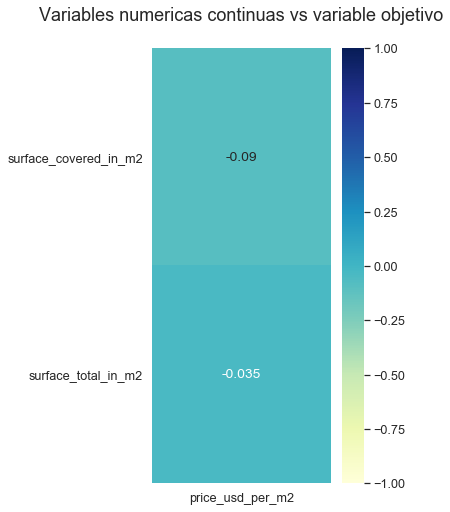

In [105]:
fig = plt.figure(figsize=(4, 8))
plt.title('Variables numericas continuas vs variable objetivo', y=1.05, fontsize=18)

yticks = sf_usd_vs.columns[1:]

sns.heatmap(sf_usd_vs.corr().iloc[1:,0].to_frame().sort_values(by='price_usd_per_m2'), annot=True,vmin=-1, yticklabels=yticks, vmax=1, cmap='YlGnBu');

plt.yticks(rotation=0) 

plt.show()

### Correlacion entre variables numericas discretas con respecto a la variable target.

#### La variable objetivo

In [106]:
m2_usd_vs = data.loc[:, ['price_usd_per_m2', 'cochera', 'piscina', 'parrilla', 'baulera', 'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad', 'metrobus']].corr()
pt_usd_vs = data.loc[:, ['price_usd_per_m2', 'property_type']]

In [107]:
pt_usd_vs = pd.get_dummies(data.property_type)
pt_usd_vs = pt_usd_vs.join(data.loc[:, 'price_usd_per_m2'])

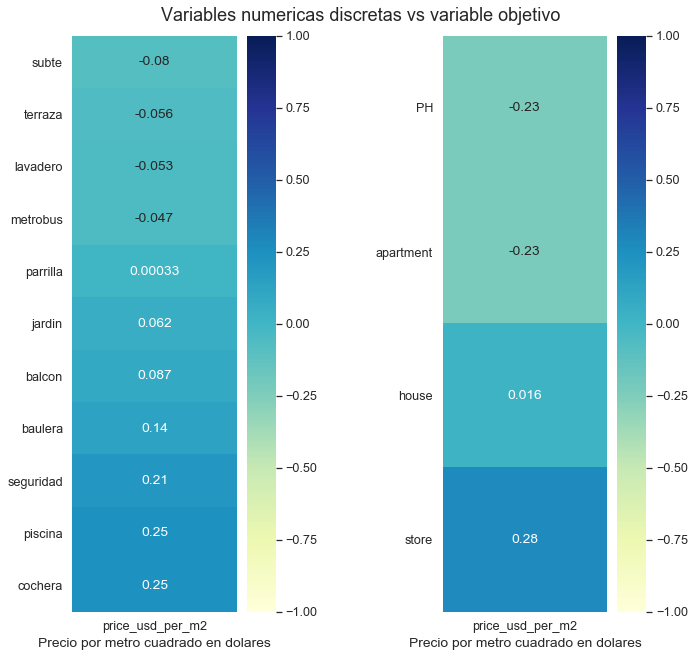

In [108]:
fig, axs = plt.subplots(1,2,figsize=(8,8))
fig.suptitle('Variables numericas discretas vs variable objetivo', y=1.05, fontsize=18)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.8, hspace=0.2)

yticks = pt_usd_vs.columns[:-1]

sns.heatmap(m2_usd_vs.iloc[1:,0].to_frame().sort_values(by='price_usd_per_m2'), annot=True,vmin=-1, vmax=1, cmap='YlGnBu', ax=axs[0]);
axs[0].set(xlabel='Precio por metro cuadrado en dolares')

sns.heatmap(pt_usd_vs.corr().iloc[:-1,-1].to_frame().sort_values(by='price_usd_per_m2'), annot=True,vmin=-1, vmax=1, cmap='YlGnBu', yticklabels=yticks, ax=axs[1]);
axs[1].set(xlabel='Precio por metro cuadrado en dolares')

plt.yticks(rotation=0) 

plt.show()

---

In [109]:
property_type_dummies = pd.get_dummies(data.property_type, prefix='prop_type', drop_first = True)
data = pd.concat([data, property_type_dummies], axis=1)

In [110]:
place_name_dummies = pd.get_dummies(data.place_name, prefix='pn', drop_first = True)
data = pd.concat([data, place_name_dummies], axis=1)

### Eliminacion de nulos y columnas sin uso

In [111]:
caba_place_name_mask = data.place_name != 'Capital Federal'
surface_total_in_m2_notnull = data.surface_total_in_m2.notnull()
price_usd_per_m2_mask_notnull = data.price_usd_per_m2.notnull()

In [112]:
data = data.loc[caba_place_name_mask & surface_total_in_m2_notnull & price_usd_per_m2_mask_notnull]

In [113]:
data.shape

(19542, 105)

In [114]:
erase_columns = ['property_type', 'place_with_parent_names', 'country_name', 'price_per_m2','state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name']

In [115]:
data = data.drop(data[erase_columns], axis=1)

In [116]:
data.columns

Index(['Id_caso', 'price_aprox_usd', 'floor', 'rooms', 'geonames_id',
       'price_usd_per_m2', 'surface_total_in_m2', 'surface_covered_in_m2',
       'cochera', 'piscina', 'parrilla', 'baulera', 'balcon', 'terraza',
       'jardin', 'lavadero', 'subte', 'seguridad', 'metrobus',
       'price_usd_per_m2_imputado', 'surface_total_in_m2_imputado',
       'prop_type_apartment', 'prop_type_house', 'prop_type_store',
       'pn_Agronomía', 'pn_Almagro', 'pn_Balvanera', 'pn_Barracas',
       'pn_Barrio Norte', 'pn_Belgrano', 'pn_Boca', 'pn_Boedo', 'pn_Caballito',
       'pn_Capital Federal', 'pn_Catalinas', 'pn_Centro / Microcentro',
       'pn_Chacarita', 'pn_Coghlan', 'pn_Colegiales', 'pn_Congreso',
       'pn_Constitución', 'pn_Flores', 'pn_Floresta', 'pn_Las Cañitas',
       'pn_Liniers', 'pn_Mataderos', 'pn_Monserrat', 'pn_Monte Castro',
       'pn_Nuñez', 'pn_Once', 'pn_Palermo', 'pn_Palermo Chico',
       'pn_Palermo Hollywood', 'pn_Palermo Soho', 'pn_Palermo Viejo',
       'pn_Parqu

---

In [117]:
data.shape

(19542, 85)

---

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

Fin depuracion dataframe y prueba inicial
---

---

In [119]:
# modelo 1 (con todas las features)

model = LinearRegression(fit_intercept=True)

feature_cols = [#'rooms',
'surface_total_in_m2',
 'cochera',
 'piscina',
 'parrilla',
 'baulera',
 'balcon',
 'terraza',
 'jardin',
 'lavadero',
 'subte',
 'seguridad',
 'metrobus',
 'prop_type_apartment',
 'prop_type_house',
 'prop_type_store',
 'pn_Agronomía',
 'pn_Almagro',
 'pn_Balvanera',
 'pn_Barracas',
 'pn_Barrio Norte',
 'pn_Belgrano',
 'pn_Boca',
 'pn_Boedo',
 'pn_Caballito',
 'pn_Catalinas',
 'pn_Centro / Microcentro',
 'pn_Chacarita',
 'pn_Coghlan',
 'pn_Colegiales',
 'pn_Congreso',
 'pn_Constitución',
 'pn_Flores',
 'pn_Floresta',
 'pn_Las Cañitas',
 'pn_Liniers',
 'pn_Mataderos',
 'pn_Monserrat',
 'pn_Monte Castro',
 'pn_Nuñez',
 'pn_Once',
 'pn_Palermo',
 'pn_Palermo Chico',
 'pn_Palermo Hollywood',
 'pn_Palermo Soho',
 'pn_Palermo Viejo',
 'pn_Parque Avellaneda',
 'pn_Parque Centenario',
 'pn_Parque Chacabuco',
 'pn_Parque Chas',
 'pn_Parque Patricios',
 'pn_Paternal',
 'pn_Pompeya',
 'pn_Puerto Madero',
 'pn_Recoleta',
 'pn_Retiro',
 'pn_Saavedra',
 'pn_San Cristobal',
 'pn_San Nicolás',
 'pn_San Telmo',
 'pn_Tribunales',
 'pn_Velez Sarsfield',
 'pn_Versalles',
 'pn_Villa Crespo',
 'pn_Villa Devoto',
 'pn_Villa General Mitre',
 'pn_Villa Lugano',
 'pn_Villa Luro',
 'pn_Villa Ortuzar',
 'pn_Villa Pueyrredón',
 'pn_Villa Real',
 #'pn_Villa Riachuelo',
 'pn_Villa Santa Rita',
 'pn_Villa Soldati',
 'pn_Villa Urquiza',
 'pn_Villa del Parque']
X = data[feature_cols]
y = data.price_usd_per_m2

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(3))

MAE: 424.53
MSE: 349823.28
RMSE: 591.46
R2: 0.633


In [120]:
r2_modelo_1_train = r2_score(ytrain, ypred_train).round(3)
r2_modelo_1_test = r2_score(ytest, ypred).round(3)
r2_modelo_1 = [r2_modelo_1_train,r2_modelo_1_test]
r2_modelo_1

[0.634, 0.633]

In [121]:
# modelo 2 (con features con correlacion mayor a 0,1)

model = LinearRegression(fit_intercept=True)

feature_cols = [#'rooms',
'surface_total_in_m2',
 'cochera',
 'piscina',
#  'parrilla',
 'baulera',
#  'balcon',
#  'terraza',
#  'jardin',
#  'lavadero',
#  'subte',
 'seguridad',
#  'metrobus',
 'prop_type_apartment',
 'prop_type_house',
 'prop_type_store',
 'pn_Agronomía',
 'pn_Almagro',
 'pn_Balvanera',
 'pn_Barracas',
 'pn_Barrio Norte',
 'pn_Belgrano',
 'pn_Boca',
 'pn_Boedo',
 'pn_Caballito',
 'pn_Catalinas',
 'pn_Centro / Microcentro',
 'pn_Chacarita',
 'pn_Coghlan',
 'pn_Colegiales',
 'pn_Congreso',
 'pn_Constitución',
 'pn_Flores',
 'pn_Floresta',
 'pn_Las Cañitas',
 'pn_Liniers',
 'pn_Mataderos',
 'pn_Monserrat',
 'pn_Monte Castro',
 'pn_Nuñez',
 'pn_Once',
 'pn_Palermo',
 'pn_Palermo Chico',
 'pn_Palermo Hollywood',
 'pn_Palermo Soho',
 'pn_Palermo Viejo',
 'pn_Parque Avellaneda',
 'pn_Parque Centenario',
 'pn_Parque Chacabuco',
 'pn_Parque Chas',
 'pn_Parque Patricios',
 'pn_Paternal',
 'pn_Pompeya',
 'pn_Puerto Madero',
 'pn_Recoleta',
 'pn_Retiro',
 'pn_Saavedra',
 'pn_San Cristobal',
 'pn_San Nicolás',
 'pn_San Telmo',
 'pn_Tribunales',
 'pn_Velez Sarsfield',
 'pn_Versalles',
 'pn_Villa Crespo',
 'pn_Villa Devoto',
 'pn_Villa General Mitre',
 'pn_Villa Lugano',
 'pn_Villa Luro',
 'pn_Villa Ortuzar',
 'pn_Villa Pueyrredón',
 'pn_Villa Real',
 #'pn_Villa Riachuelo',
 'pn_Villa Santa Rita',
 'pn_Villa Soldati',
 'pn_Villa Urquiza',
 'pn_Villa del Parque']
X = data[feature_cols]
y = data.price_usd_per_m2

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(3))

MAE: 426.62
MSE: 353701.82
RMSE: 594.73
R2: 0.629


In [122]:
r2_modelo_2_train = r2_score(ytrain, ypred_train).round(3)
r2_modelo_2_test = r2_score(ytest, ypred).round(3)
r2_modelo_2 = [r2_modelo_2_train,r2_modelo_2_test]
r2_modelo_2

[0.63, 0.629]

In [123]:
data['surface_total_in_m2_x2'] = data['surface_total_in_m2']**2
data['surface_total_in_m2_x3'] = data['surface_total_in_m2']**3
data['surface_total_in_m2_x4'] = data['surface_total_in_m2']**4
data['surface_total_in_m2_x5'] = data['surface_total_in_m2']**5
data['surface_total_in_m2_x6'] = data['surface_total_in_m2']**6

In [124]:
# modelo 3 (trabajo con polinomios de variables)

model = LinearRegression(fit_intercept=True)

feature_cols = [
#'rooms',
'surface_total_in_m2',
 'cochera',
 'piscina',
 'parrilla',
 'baulera',
 'balcon',
  'terraza',
  'jardin',
  'lavadero',
'subte',
 'seguridad',
'metrobus',
'surface_total_in_m2_x2',
#  'surface_total_in_m2_x3',
 'prop_type_apartment',
 'prop_type_house',
 'prop_type_store',
 'pn_Agronomía',
 'pn_Almagro',
 'pn_Balvanera',
 'pn_Barracas',
 'pn_Barrio Norte',
 'pn_Belgrano',
 'pn_Boca',
 'pn_Boedo',
 'pn_Caballito',
 'pn_Catalinas',
 'pn_Centro / Microcentro',
 'pn_Chacarita',
 'pn_Coghlan',
 'pn_Colegiales',
 'pn_Congreso',
 'pn_Constitución',
 'pn_Flores',
 'pn_Floresta',
 'pn_Las Cañitas',
 'pn_Liniers',
 'pn_Mataderos',
 'pn_Monserrat',
 'pn_Monte Castro',
 'pn_Nuñez',
 'pn_Once',
 'pn_Palermo',
 'pn_Palermo Chico',
 'pn_Palermo Hollywood',
 'pn_Palermo Soho',
 'pn_Palermo Viejo',
 'pn_Parque Avellaneda',
 'pn_Parque Centenario',
 'pn_Parque Chacabuco',
 'pn_Parque Chas',
 'pn_Parque Patricios',
 'pn_Paternal',
 'pn_Pompeya',
 'pn_Puerto Madero',
 'pn_Recoleta',
 'pn_Retiro',
 'pn_Saavedra',
 'pn_San Cristobal',
 'pn_San Nicolás',
 'pn_San Telmo',
 'pn_Tribunales',
 'pn_Velez Sarsfield',
 'pn_Versalles',
 'pn_Villa Crespo',
 'pn_Villa Devoto',
 'pn_Villa General Mitre',
 'pn_Villa Lugano',
 'pn_Villa Luro',
 'pn_Villa Ortuzar',
 'pn_Villa Pueyrredón',
 'pn_Villa Real',
 #'pn_Villa Riachuelo',
 'pn_Villa Santa Rita',
 'pn_Villa Soldati',
 'pn_Villa Urquiza',
 'pn_Villa del Parque'
]
X = data[feature_cols]
y = data.price_usd_per_m2

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(3))

MAE: 422.78
MSE: 348605.78
RMSE: 590.43
R2: 0.634


In [125]:
r2_modelo_3_train = r2_score(ytrain, ypred_train).round(3)
r2_modelo_3_test = r2_score(ytest, ypred).round(3)
r2_modelo_3 = [r2_modelo_3_train, r2_modelo_3_test]
r2_modelo_3

[0.639, 0.634]

In [126]:
# modelo 4 (sin surface_total_in_m2)

model = LinearRegression(fit_intercept=True)

feature_cols = [
 'cochera',
 'piscina',
 'parrilla',
 'baulera',
 'balcon',
  'terraza',
  'jardin',
  'lavadero',
'subte',
 'seguridad',
'metrobus',
 'prop_type_apartment',
 'prop_type_house',
 'prop_type_store',
 'pn_Agronomía',
 'pn_Almagro',
 'pn_Balvanera',
 'pn_Barracas',
 'pn_Barrio Norte',
 'pn_Belgrano',
 'pn_Boca',
 'pn_Boedo',
 'pn_Caballito',
 'pn_Catalinas',
 'pn_Centro / Microcentro',
 'pn_Chacarita',
 'pn_Coghlan',
 'pn_Colegiales',
 'pn_Congreso',
 'pn_Constitución',
 'pn_Flores',
 'pn_Floresta',
 'pn_Las Cañitas',
 'pn_Liniers',
 'pn_Mataderos',
 'pn_Monserrat',
 'pn_Monte Castro',
 'pn_Nuñez',
 'pn_Once',
 'pn_Palermo',
 'pn_Palermo Chico',
 'pn_Palermo Hollywood',
 'pn_Palermo Soho',
 'pn_Palermo Viejo',
 'pn_Parque Avellaneda',
 'pn_Parque Centenario',
 'pn_Parque Chacabuco',
 'pn_Parque Chas',
 'pn_Parque Patricios',
 'pn_Paternal',
 'pn_Pompeya',
 'pn_Puerto Madero',
 'pn_Recoleta',
 'pn_Retiro',
 'pn_Saavedra',
 'pn_San Cristobal',
 'pn_San Nicolás',
 'pn_San Telmo',
 'pn_Tribunales',
 'pn_Velez Sarsfield',
 'pn_Versalles',
 'pn_Villa Crespo',
 'pn_Villa Devoto',
 'pn_Villa General Mitre',
 'pn_Villa Lugano',
 'pn_Villa Luro',
 'pn_Villa Ortuzar',
 'pn_Villa Pueyrredón',
 'pn_Villa Real',
 #'pn_Villa Riachuelo',
 'pn_Villa Santa Rita',
 'pn_Villa Soldati',
 'pn_Villa Urquiza',
 'pn_Villa del Parque'
]
X = data[feature_cols]
y = data.price_usd_per_m2

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(3))

MAE: 427.33
MSE: 354424.98
RMSE: 595.34
R2: 0.628


In [127]:
r2_modelo_4_train = r2_score(ytrain, ypred_train).round(3)
r2_modelo_4_test = r2_score(ytest, ypred).round(3)
r2_modelo_4 = [r2_modelo_4_train, r2_modelo_4_test]
r2_modelo_4

[0.631, 0.628]

In [128]:
# modelo 5 (sin surface_total_in_m2)

model = LinearRegression(fit_intercept=True)

feature_cols = [
 'pn_Agronomía',
 'pn_Almagro',
 'pn_Balvanera',
 'pn_Barracas',
 'pn_Barrio Norte',
 'pn_Belgrano',
 'pn_Boca',
 'pn_Boedo',
 'pn_Caballito',
 'pn_Catalinas',
 'pn_Centro / Microcentro',
 'pn_Chacarita',
 'pn_Coghlan',
 'pn_Colegiales',
 'pn_Congreso',
 'pn_Constitución',
 'pn_Flores',
 'pn_Floresta',
 'pn_Las Cañitas',
 'pn_Liniers',
 'pn_Mataderos',
 'pn_Monserrat',
 'pn_Monte Castro',
 'pn_Nuñez',
 'pn_Once',
 'pn_Palermo',
 'pn_Palermo Chico',
 'pn_Palermo Hollywood',
 'pn_Palermo Soho',
 'pn_Palermo Viejo',
 'pn_Parque Avellaneda',
 'pn_Parque Centenario',
 'pn_Parque Chacabuco',
 'pn_Parque Chas',
 'pn_Parque Patricios',
 'pn_Paternal',
 'pn_Pompeya',
 'pn_Puerto Madero',
 'pn_Recoleta',
 'pn_Retiro',
 'pn_Saavedra',
 'pn_San Cristobal',
 'pn_San Nicolás',
 'pn_San Telmo',
 'pn_Tribunales',
 'pn_Velez Sarsfield',
 'pn_Versalles',
 'pn_Villa Crespo',
 'pn_Villa Devoto',
 'pn_Villa General Mitre',
 'pn_Villa Lugano',
 'pn_Villa Luro',
 'pn_Villa Ortuzar',
 'pn_Villa Pueyrredón',
 'pn_Villa Real',
 #'pn_Villa Riachuelo',
 'pn_Villa Santa Rita',
 'pn_Villa Soldati',
 'pn_Villa Urquiza',
 'pn_Villa del Parque'
]
X = data[feature_cols]
y = data.price_usd_per_m2

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(3))

MAE: 471.46
MSE: 417645.74
RMSE: 646.26
R2: 0.562


In [129]:
r2_modelo_5_train = r2_score(ytrain, ypred_train).round(3)
r2_modelo_5_test = r2_score(ytest, ypred).round(3)
r2_modelo_5 = [r2_modelo_5_train, r2_modelo_5_test]

In [130]:
data_chart = [r2_modelo_1]+[r2_modelo_2]+[r2_modelo_3]+[r2_modelo_4]+[r2_modelo_5]
hue = 'R2 Test', 'R2 Train'
labels = ['Todas las features', 'Features corr() > 0.1', 'Polinomio de grado 6', 'Sin m2 totales', 'Sólo barrios']

In [131]:
df_chart = pd.DataFrame(np.around(data_chart,2), columns=['R2 Test', 'R2 Train'], index=labels)

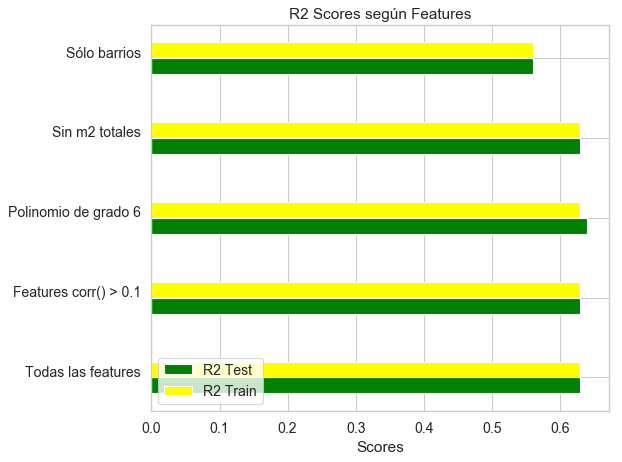

In [132]:
labels = df_chart.index
y = np.arange(len(labels))
width = 0.20

fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
rects1 = ax.barh(y - width/2,  df_chart.loc[:,'R2 Test'], width, label='R2 Test', color='green')
rects2 = ax.barh(y + width/2, df_chart.loc[:,'R2 Train'], width, label='R2 Train', color='yellow')

ax.set_xlabel('Scores')
ax.set_title('R2 Scores según Features')
ax.set_yticks(y)
ax.set_yticklabels(labels,rotation_mode="anchor", ha="right")
ax.legend(loc='lower left')

fig.tight_layout()

plt.show()

In [133]:
import statsmodels.api as sm

In [134]:
Xs = data[['surface_total_in_m2',
 'cochera',
 'piscina',
 'parrilla',
 'baulera',
 'balcon',
 'terraza',
 'jardin',
 'lavadero',
 'subte',
 'seguridad',
 'metrobus',
 'prop_type_apartment',
 'prop_type_house',
 'prop_type_store',
 'pn_Agronomía',
 'pn_Almagro',
 'pn_Balvanera',
 'pn_Barracas',
 'pn_Barrio Norte',
 'pn_Belgrano',
 'pn_Boca',
 'pn_Boedo',
 'pn_Caballito',
 'pn_Catalinas',
 'pn_Centro / Microcentro',
 'pn_Chacarita',
 'pn_Coghlan',
 'pn_Colegiales',
 'pn_Congreso',
 'pn_Constitución',
 'pn_Flores',
 'pn_Floresta',
 'pn_Las Cañitas',
 'pn_Liniers',
 'pn_Mataderos',
 'pn_Monserrat',
 'pn_Monte Castro',
 'pn_Nuñez',
 'pn_Once',
 'pn_Palermo',
 'pn_Palermo Chico',
 'pn_Palermo Hollywood',
 'pn_Palermo Soho',
 'pn_Palermo Viejo',
 'pn_Parque Avellaneda',
 'pn_Parque Centenario',
 'pn_Parque Chacabuco',
 'pn_Parque Chas',
 'pn_Parque Patricios',
 'pn_Paternal',
 'pn_Pompeya',
 'pn_Puerto Madero',
 'pn_Recoleta',
 'pn_Retiro',
 'pn_Saavedra',
 'pn_San Cristobal',
 'pn_San Nicolás',
 'pn_San Telmo',
 'pn_Tribunales',
 'pn_Velez Sarsfield',
 'pn_Versalles',
 'pn_Villa Crespo',
 'pn_Villa Devoto',
 'pn_Villa General Mitre',
 'pn_Villa Lugano',
 'pn_Villa Luro',
 'pn_Villa Ortuzar',
 'pn_Villa Pueyrredón',
 'pn_Villa Real',
 #'pn_Villa Riachuelo',
 'pn_Villa Santa Rita',
 'pn_Villa Soldati',
 'pn_Villa Urquiza',
 'pn_Villa del Parque']]
ys = data[["price_usd_per_m2"]]

X = sm.add_constant(Xs)



model = sm.OLS(ys.astype(float), X.astype(float)).fit()
predictions = model.predict(X)
print ("EMC:", mean_squared_error(ys, predictions))
print (model.summary())

EMC: 340375.5181692208
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     463.0
Date:                Sat, 15 Aug 2020   Prob (F-statistic):               0.00
Time:                        02:37:32   Log-Likelihood:            -1.5219e+05
No. Observations:               19542   AIC:                         3.045e+05
Df Residuals:                   19468   BIC:                         3.051e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
con

### Portafolio

In [135]:
# modelo 1 (con todas las features)
model = LinearRegression(fit_intercept=True)

feature_cols = [#'rooms',
'surface_total_in_m2',
 'cochera',
 'piscina',
 'parrilla',
 'baulera',
 'balcon',
 'terraza',
 'jardin',
 'lavadero',
 'subte',
 'seguridad',
 'metrobus',
 'prop_type_apartment',
 'prop_type_house',
 'prop_type_store',
 'pn_Agronomía',
 'pn_Almagro',
 'pn_Balvanera',
 'pn_Barracas',
 'pn_Barrio Norte',
 'pn_Belgrano',
 'pn_Boca',
 'pn_Boedo',
 'pn_Caballito',
 'pn_Catalinas',
 'pn_Centro / Microcentro',
 'pn_Chacarita',
 'pn_Coghlan',
 'pn_Colegiales',
 'pn_Congreso',
 'pn_Constitución',
 'pn_Flores',
 'pn_Floresta',
 'pn_Las Cañitas',
 'pn_Liniers',
 'pn_Mataderos',
 'pn_Monserrat',
 'pn_Monte Castro',
 'pn_Nuñez',
 'pn_Once',
 'pn_Palermo',
 'pn_Palermo Chico',
 'pn_Palermo Hollywood',
 'pn_Palermo Soho',
 'pn_Palermo Viejo',
 'pn_Parque Avellaneda',
 'pn_Parque Centenario',
 'pn_Parque Chacabuco',
 'pn_Parque Chas',
 'pn_Parque Patricios',
 'pn_Paternal',
 'pn_Pompeya',
 'pn_Puerto Madero',
 'pn_Recoleta',
 'pn_Retiro',
 'pn_Saavedra',
 'pn_San Cristobal',
 'pn_San Nicolás',
 'pn_San Telmo',
 'pn_Tribunales',
 'pn_Velez Sarsfield',
 'pn_Versalles',
 'pn_Villa Crespo',
 'pn_Villa Devoto',
 'pn_Villa General Mitre',
 'pn_Villa Lugano',
 'pn_Villa Luro',
 'pn_Villa Ortuzar',
 'pn_Villa Pueyrredón',
 'pn_Villa Real',
 #'pn_Villa Riachuelo',
 'pn_Villa Santa Rita',
 'pn_Villa Soldati',
 'pn_Villa Urquiza',
 'pn_Villa del Parque']

X = data[feature_cols]
y = data.price_usd_per_m2

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(X)

In [136]:
data['price_usd_per_m2_pred'] = ypred

In [137]:
data['price_aprox_usd_pred'] = data['price_usd_per_m2_pred'] * data.surface_total_in_m2

In [138]:
data['diferencia_valuacion'] = data.price_usd_per_m2 - data.price_usd_per_m2_pred

In [139]:
portafolio = data.loc[:,['Id_caso','price_aprox_usd','price_aprox_usd_pred','diferencia_valuacion','price_usd_per_m2','price_usd_per_m2_pred','surface_total_in_m2']].sample(100)
portafolio.shape

(100, 7)

In [140]:
para_comprar = data.price_usd_per_m2 < data.price_usd_per_m2_pred
para_vender = data.price_usd_per_m2 > data.price_usd_per_m2_pred

In [141]:
para_comprar.sum(), para_vender.sum()

(10261, 9281)

#### Para vender
La diferencia positiva es a favor del vendendor

In [142]:
portafolio.loc[para_vender,:].sort_values(by='diferencia_valuacion',ascending=False)
ingreso = (portafolio.loc[para_vender,:].price_usd_per_m2 * portafolio.loc[para_vender,:].surface_total_in_m2).sum()
print(portafolio.loc[para_vender,:].sort_values(by='diferencia_valuacion',ascending=False).shape)
print(ingreso)

(48, 7)
14046596.575


#### Para Comprar
La diferencia negativa es a favor del comprador -> ¿cuán debajo está el precio estimado del precio final?

In [143]:
portafolio.loc[para_comprar,:].sort_values(by='diferencia_valuacion').shape
egreso = (portafolio.loc[para_comprar,:].price_usd_per_m2 * portafolio.loc[para_comprar,:].surface_total_in_m2).sum()
print(portafolio.loc[para_comprar,:].sort_values(by='diferencia_valuacion',ascending=False).shape)
print(egreso)

(52, 7)
9721453.84


#### ¿Qué y cuánto comprar con los ingresos?

In [144]:
ingreso

14046596.575